# AI-2: Convolutional Neural Network
## PROJECT: CAR DAMAGE ASSESSMENT

**AI2 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Ignacio Becker<br />

<hr style="height:2.4pt">

### Names of the people who worked on this projecy together
<font color='red'>/Bhaskar Bharat and Ekanki Agarwal/</font>

## PROJECT MOTIVATION

To reduce Claims leakage during Car Insurance processing, visual inspection and validation are done. This inspection takes a long time as the official from insurance company needs to come and inspect the damage physically. This results in delaying of claims processing. An automated system for doing inspection and validation will be of great help in speeding up the process.

## HIGH-LEVEL APPROACH

We are trying to automate the Visual inspection and validation of vehicle damage. The input data we have are images of damaged and non-damaged cars.

For Validation of Vehicle damage we will divide the problem into three stages.

1. First we check whether the given input image of car has been damaged or not.
2. Second we check on which side (Front, Rear, Side) the Car in the image has been damaged.
3. Third we check for the Severity of damage (Minor, Moderate, Severe).

This problem is a classification problem and since we will be dealing with images as input, we will be using Convolutional Neural Networks (CNN).

We will be doing transfer learning using VGG16, VGG19, Resnet and Densenet, and see which one performs better.

## PERFORMANCE METRICS

We are using Accuracy, Precision and Recall as performance metrics.

To calculate Accuracy, Precision and Recall we need to construct confusion matrix. 

Formulas for above are given below.
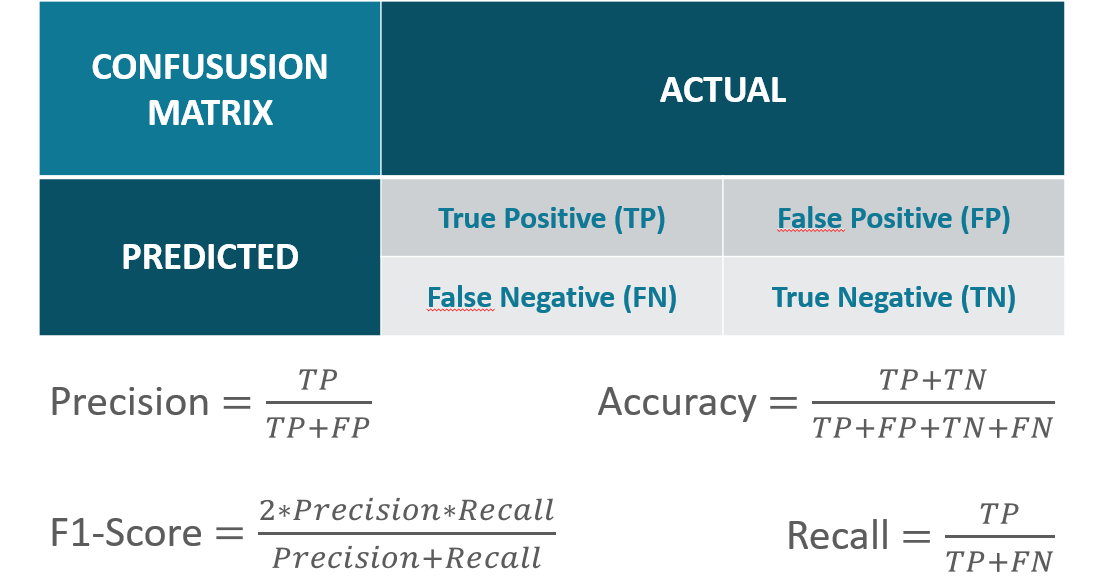

## DATASET SOURCE

Since the dataset for damaged cars are rare. The car dataset is downloaded from:

https://www.kaggle.com/anujms/car-damage-detection

https://drive.google.com/drive/folders/1MGGTS3JlgqE9W8d9LoV3ZE-XJIEiwcPP?usp=sharing

Inspiration for this project was drawn from this medium article: https://medium.com/analytics-vidhya/car-damage-classification-using-deep-learning-d29fa1e9a520

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## IMPORTING REQUIRED LIBRARIES

In [ ]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
print(working_dir)
os.chdir(working_dir)

/content


In [ ]:
# Please download the 2.1.0 version of tensorflow for this homework and also tf_keras_vis
!pip3 -qq install tf_keras_vis 
!pip -qq install tensorflow==2.1.0

     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 448 kB 48.1 MB/s 
     |████████████████████████████████| 3.8 MB 33.1 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [ ]:
# Installing h5py package to work with .h5 file formats
!pip install h5py==2.10.0 --force-reinstall

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
     |████████████████████████████████| 15.7 MB 30.0 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which 

In [ ]:
!pip install tensorflow-addons==0.9.1

     |████████████████████████████████| 1.0 MB 4.3 MB/s 


In [ ]:
import os
import requests
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from tqdm import tqdm

import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage

from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import Accuracy, Precision, Recall

from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, History

import tensorflow_addons as tfa

from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

import json

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Pysical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.1.0
keras version 2.2.4-tf
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Pysical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## EDA
We have three types of Datasets:

1. Training and Test folders of Damaged and Not Damaged car images.
2. Training and Test folders of Car Damage on Front, Rear and Side.
3. Training and Test folders of Car Damage severity, that is, Minor, Moderate and Severe.

### Data - 1

In [ ]:
DATA1_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/data1'

In [ ]:
DATA1_TRAIN_PATH = DATA1_PATH + '/training'
DATA1_TEST_PATH = DATA1_PATH + '/validation'

TRAIN_DAMAGE_PATH = DATA1_TRAIN_PATH + '/damage'
TRAIN_WHOLE_PATH = DATA1_TRAIN_PATH + '/whole'

TEST_DAMAGE_PATH = DATA1_TEST_PATH + '/damage'
TEST_WHOLE_PATH = DATA1_TEST_PATH + '/whole'

In [ ]:
train_damage = os.listdir(TRAIN_DAMAGE_PATH)
train_whole = os.listdir(TRAIN_WHOLE_PATH)

test_damage = os.listdir(TEST_DAMAGE_PATH)
test_whole = os.listdir(TEST_WHOLE_PATH)

In [ ]:
# Checking how many images are there in the Train and Test set
print(f"Number of images in Train Set : {len(train_damage)+len(train_whole)}")
print(f"Number of images in Test Set : {len(test_damage)+len(test_whole)}")

Number of images in Train Set : 1840
Number of images in Test Set : 460


In [ ]:
def plot_bar(classes, percents, name):
  plt.figure(figsize = (5,5))
  f = sns.barplot(x = classes,y =percents)
  plt.xlabel("Class labels", fontsize=12)
  plt.ylabel('Percentage', fontsize=12)
  plt.title("Percentage of Images in "+name+' folder', fontsize=15)
  plt.show()

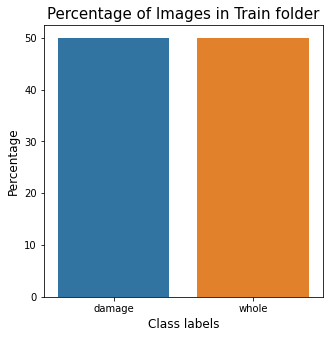

In [ ]:
# Checking whether the train data is balanced
classes = ['damage', 'whole']
total_count = len(train_damage)+len(train_whole)
percents = [100*(len(train_damage)/total_count), 100*(len(train_whole)/total_count)]
plot_bar(classes, percents, 'Train')

**Observations:**
1. From the train plot we can see that the images we have for Damage and Whole classes are equal.
2. There is no class imbalance.

### Data - 2

In [ ]:
DATA2_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/data2'

In [ ]:
DATA2_TRAIN_PATH = DATA2_PATH + '/training'
DATA2_TEST_PATH = DATA2_PATH + '/validation'

TRAIN_FRONT_PATH = DATA2_TRAIN_PATH + '/front'
TRAIN_REAR_PATH = DATA2_TRAIN_PATH + '/rear'
TRAIN_SIDE_PATH = DATA2_TRAIN_PATH + '/side'

TEST_FRONT_PATH = DATA2_TEST_PATH + '/front'
TEST_REAR_PATH = DATA2_TEST_PATH + '/rear'
TEST_SIDE_PATH = DATA2_TEST_PATH + '/side'

In [ ]:
train_front = os.listdir(TRAIN_FRONT_PATH)
train_rear = os.listdir(TRAIN_REAR_PATH)
train_side = os.listdir(TRAIN_SIDE_PATH)

test_front = os.listdir(TEST_FRONT_PATH)
test_rear = os.listdir(TEST_REAR_PATH)
test_side = os.listdir(TEST_SIDE_PATH)

In [ ]:
# Checking how many images are there in the Train and Test set
print(f"Number of images in Train Set : {len(train_front)+len(train_rear)+len(train_side)}")
print(f"Number of images in Test Set : {len(test_front)+len(test_rear)+len(test_side)}")

Number of images in Train Set : 985
Number of images in Test Set : 179


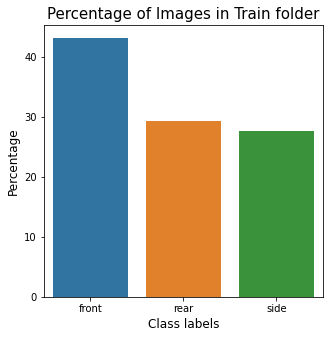

In [ ]:
# Checking whether the train data is balanced
classes = ['front', 'rear', 'side']
total_count = len(train_front)+len(train_rear)+len(train_side)
percents = [100*(len(train_front)/total_count), 100*(len(train_rear)/total_count), 100*(len(train_side)/total_count)]
plot_bar(classes, percents, 'Train')

**Observations:**
1. From the train plot we can see that the images we have for Front, Rear and Side are not equal.
2. We have more front images and counts of rear and side are almost equal.

### Data - 3

In [ ]:
DATA3_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/data3'

In [ ]:
DATA3_TRAIN_PATH = DATA3_PATH + '/training'
DATA3_TEST_PATH = DATA3_PATH + '/validation'

TRAIN_MINOR_PATH = DATA3_TRAIN_PATH + '/minor'
TRAIN_MODERATE_PATH = DATA3_TRAIN_PATH + '/moderate'
TRAIN_SEVERE_PATH = DATA3_TRAIN_PATH + '/severe'

TEST_MINOR_PATH = DATA3_TEST_PATH + '/minor'
TEST_MODERATE_PATH = DATA3_TEST_PATH + '/moderate'
TEST_SEVERE_PATH = DATA3_TEST_PATH + '/severe'

In [ ]:
train_minor = os.listdir(TRAIN_MINOR_PATH)
train_moderate = os.listdir(TRAIN_MODERATE_PATH)
train_severe = os.listdir(TRAIN_SEVERE_PATH)

test_minor = os.listdir(TEST_MINOR_PATH)
test_moderate = os.listdir(TEST_MODERATE_PATH)
test_severe = os.listdir(TEST_SEVERE_PATH)

In [ ]:
# Checking how many images are there in the Train and Test set
print(f"Number of images in Train Set : {len(train_minor)+len(train_moderate)+len(train_severe)}")
print(f"Number of images in Test Set : {len(test_minor)+len(test_moderate)+len(test_severe)}")

Number of images in Train Set : 979
Number of images in Test Set : 171


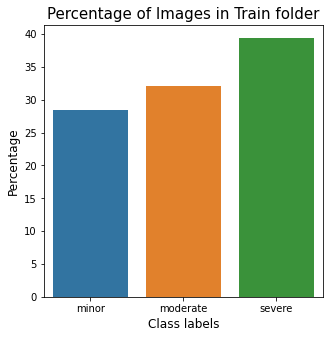

In [ ]:
# Checking whether the train data is balanced
classes = ['minor', 'moderate', 'severe']
total_count = len(train_minor)+len(train_moderate)+len(train_severe)
percents = [100*(len(train_minor)/total_count), 100*(len(train_moderate)/total_count), 100*(len(train_severe)/total_count)]
plot_bar(classes, percents, 'Train')

**Observations:**
1. From the train plot we can see that the images we have for Minor, Moderate and Severe are not equal.
2. We have more Severe images and less images in minor and moderate classes.

## MODELLING ON DATA - 1

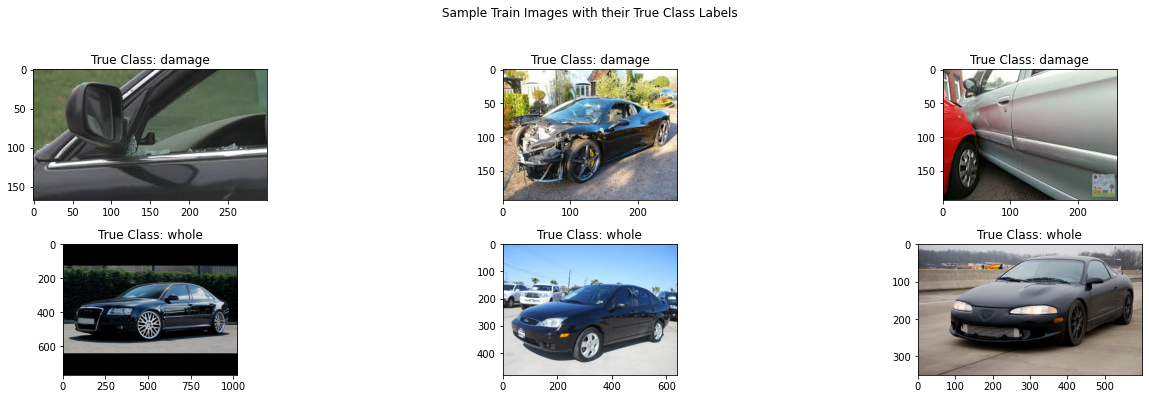

In [ ]:
# Plotting Sample Train Images with their True Class Labels

damage_idx = np.random.randint(0, len(train_damage), 3)
whole_idx = np.random.randint(0, len(train_whole), 3)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,5))

for i in range(3):
  image = Image.open(TRAIN_DAMAGE_PATH+'/'+train_damage[damage_idx[i]])
  image = np.array(image)
  ax[0, i].imshow(image)
  ax[0, i].set_title('True Class: damage')

for i in range(3):
  image = Image.open(TRAIN_WHOLE_PATH+'/'+train_whole[whole_idx[i]])
  image = np.array(image)
  ax[1, i].imshow(image)
  ax[1, i].set_title('True Class: whole')
plt.suptitle('Sample Train Images with their True Class Labels', y=1.1)
plt.tight_layout()

### DATA AUGMENTATION

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False)

Found 1472 images belonging to 2 classes.
Found 368 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


Found 1472 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


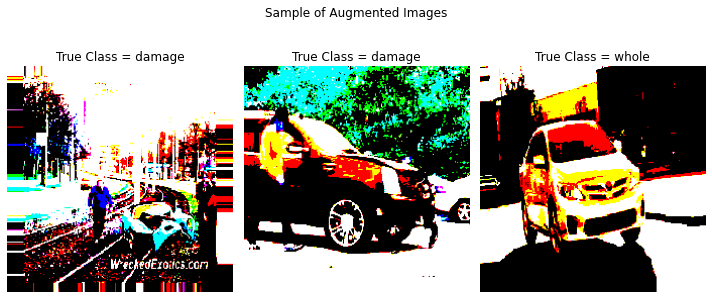

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(label)]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

### VGG19

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg16 model and setting layers as non trainable
vgg19 = applications.vgg19.VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG16 layers to non trainable
for i in range(len(vgg19.layers)):
  vgg19.layers[i].trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(vgg19.output)
X = Dense(units=256, activation='relu')(fc)
# X = Dropout(0.5)(X)
X = Dense(units=128, activation='relu')(X)
# X = Dropout(0.5)(X)
X = Dense(units=64, activation='relu')(X)
# X = Dropout(0.5)(X)
out = Dense(units=1, activation='sigmoid')(X)

vgg19_data1 = Model(inputs = vgg19.input, outputs = out)

vgg19_data1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Initializing epochs
epochs=30

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data1/vgg19'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
vgg19_data1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
vgg19_data1_history = vgg19_data1.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 6 steps
Epoch 1/30
23/23 [==============================] - 43s 2s/step - loss: 2.5156 - accuracy: 0.7310 - precision_1: 0.7450 - recall_1: 0.7024 - val_loss: 0.6653 - val_accuracy: 0.8152 - val_precision_1: 0.7320 - val_recall_1: 0.9946
Epoch 2/30
23/23 [==============================] - 42s 2s/step - loss: 0.5703 - accuracy: 0.8492 - precision_1: 0.8408 - recall_1: 0.8614 - val_loss: 0.5349 - val_accuracy: 0.8940 - val_precision_1: 0.9739 - val_recall_1: 0.8098
Epoch 3/30
23/23 [==============================] - 43s 2s/step - loss: 0.3845 - accuracy: 0.9049 - precision_1: 0.9071 - recall_1: 0.9022 - val_loss: 0.2784 - val_accuracy: 0.9348 - val_precision_1: 0.9545 - val_recall_1: 0.9130
Epoch 4/30
23/23 [==============================] - 43s 2s/step - loss: 0.3391 - accuracy: 0.9001 - precision_1: 0.9029 - recall_1: 0.8967 - val_loss: 0.2575 - val_accuracy: 0.9158 - val_precision_1: 0.8806 - val_recall

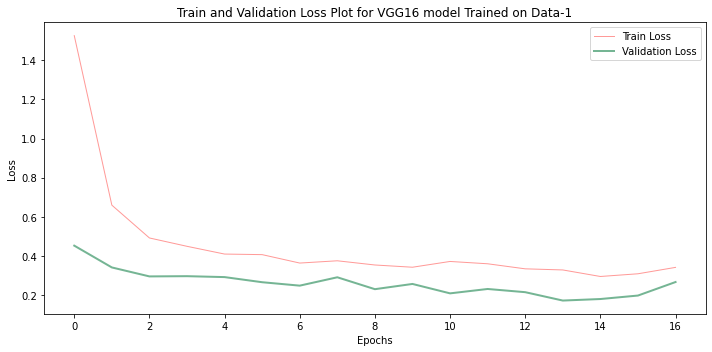

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for VGG19 model Trained on Data-1")
plt.plot(vgg19_data1_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data1_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

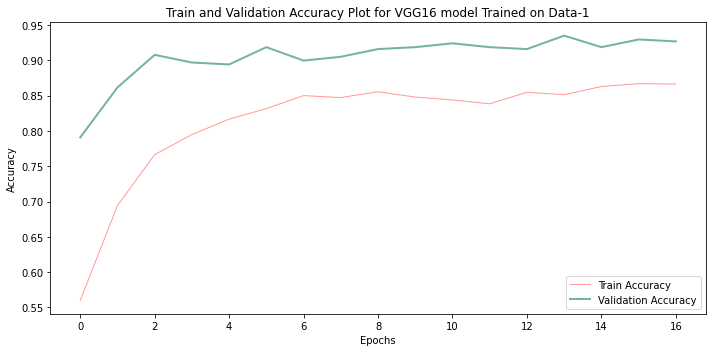

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for VGG19 model Trained on Data-1")
plt.plot(vgg19_data1_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data1_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = vgg19_data1.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
8/8 [==============================] - 100s 12s/step - loss: 0.2551 - accuracy: 0.9109 - precision_3: 0.8857 - recall_3: 0.9435
Test Loss: 0.2551
Test Accuracy: 91.0870 %
Test Precision: 88.5714 %
Test Recall: 94.3478 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


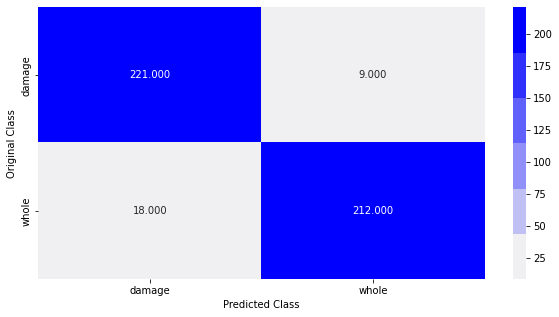

In [ ]:
#Plotting confusion matrix
test_preds_proba = vgg19_data1.predict(test_generator)
test_preds = np.where(test_preds_proba.ravel()>=0.5, 1, 0)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
vgg19_data1.save(checkpoint_filepath+'vgg19_data1.h5')

**Save Keras Training History Object**

https://androidkt.com/save-keras-training-history-object-to-file-using-callback/

https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

In [ ]:
np.save(checkpoint_filepath+'vgg19_data1_history.npy', vgg19_data1_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### Resnet152

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False)

Found 1472 images belonging to 2 classes.
Found 368 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 1472 images belonging to 2 classes.


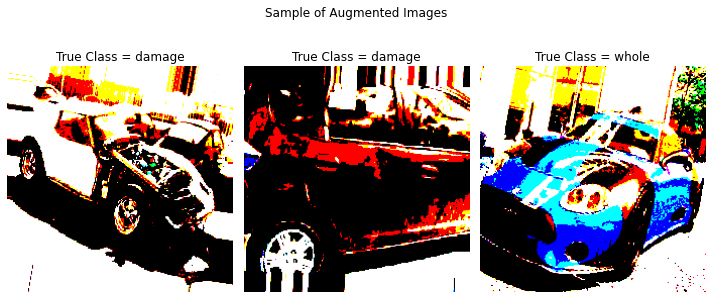

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(label)]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg16 model and setting layers as non trainable
resnet152 = applications.resnet.ResNet152(include_top = False, weights = 'imagenet', input_shape=input_shape, pooling=None)

# Setting VGG16 layers to non trainable
for i in range(len(resnet152.layers)):
  resnet152.layers[i].trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(resnet152.output)
X = Dense(units=64, activation='relu')(fc)
# X = Dropout(0.5)(X)
X = Dense(units=32, activation='relu')(X)
# X = Dropout(0.5)(X)
X = Dense(units=16, activation='relu')(X)
# X = Dropout(0.5)(X)
out = Dense(units=1, activation='sigmoid')(X)

resnet152_data1 = Model(inputs = resnet152.input, outputs = out)

resnet152_data1.summary()

234700800/234698864 [==============================] - 14s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
# Initializing epochs
epochs=30

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data1/resnet152'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
resnet152_data1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
resnet152_data1_history = resnet152_data1.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 6 steps
Epoch 1/30
23/23 [==============================] - 118s 5s/step - loss: 0.4352 - accuracy: 0.7894 - precision_2: 0.7910 - recall_2: 0.7867 - val_loss: 0.1573 - val_accuracy: 0.9484 - val_precision_2: 0.9558 - val_recall_2: 0.9402
Epoch 2/30
23/23 [==============================] - 103s 4s/step - loss: 0.2202 - accuracy: 0.9069 - precision_2: 0.9108 - recall_2: 0.9022 - val_loss: 0.1480 - val_accuracy: 0.9375 - val_precision_2: 0.9351 - val_recall_2: 0.9402
Epoch 3/30
23/23 [==============================] - 104s 5s/step - loss: 0.1744 - accuracy: 0.9355 - precision_2: 0.9384 - recall_2: 0.9321 - val_loss: 0.1434 - val_accuracy: 0.9429 - val_precision_2: 0.9267 - val_recall_2: 0.9620
Epoch 4/30
23/23 [==============================] - 42s 2s/step - loss: 0.1341 - accuracy: 0.9490 - precision_2: 0.9609 - recall_2: 0.9361 - val_loss: 0.1740 - val_accuracy: 0.9266 - val_precision_2: 0.8867 - val_rec

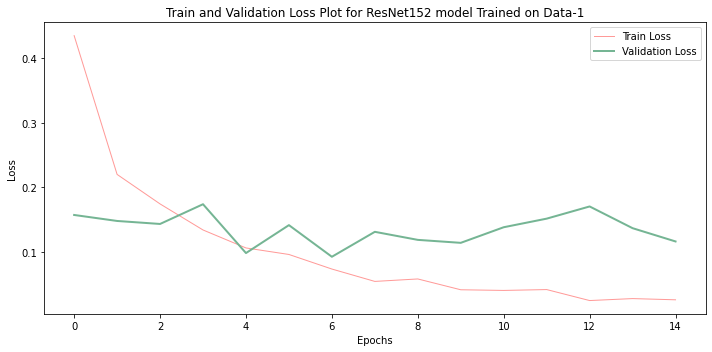

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for ResNet152 model Trained on Data-1")
plt.plot(resnet152_data1_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data1_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

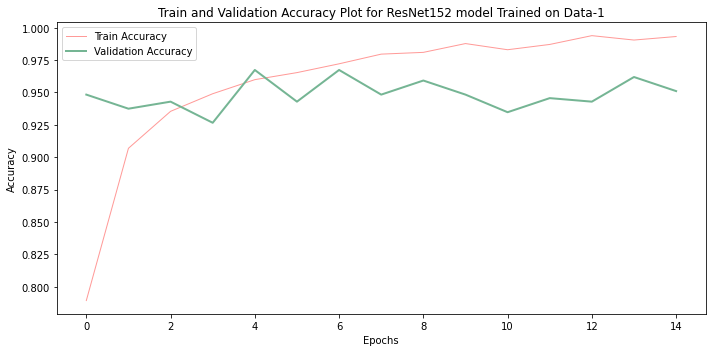

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for ResNet152 model Trained on Data-1")
plt.plot(resnet152_data1_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data1_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = resnet152_data1.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
8/8 [==============================] - 8s 1s/step - loss: 0.3039 - accuracy: 0.9391 - precision_2: 0.9430 - recall_2: 0.9348
Test Loss: 0.3039
Test Accuracy: 93.9130 %
Test Precision: 94.2982 %
Test Recall: 93.4783 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


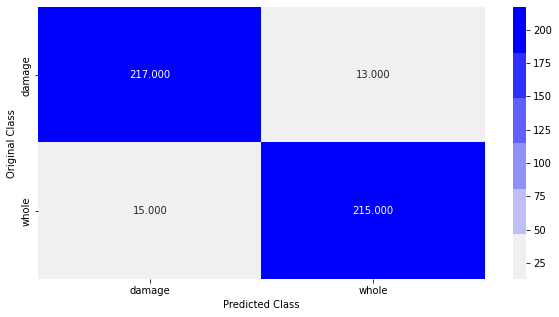

In [ ]:
#Plotting confusion matrix
test_preds_proba = resnet152_data1.predict(test_generator)
test_preds = np.where(test_preds_proba.ravel()>=0.5, 1, 0)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
resnet152_data1.save(checkpoint_filepath+'resnet152_data1.h5')

In [ ]:
np.save(checkpoint_filepath+'resnet152_data1_history.npy', resnet152_data1_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### DenseNet201

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False)

Found 1472 images belonging to 2 classes.
Found 368 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 1472 images belonging to 2 classes.


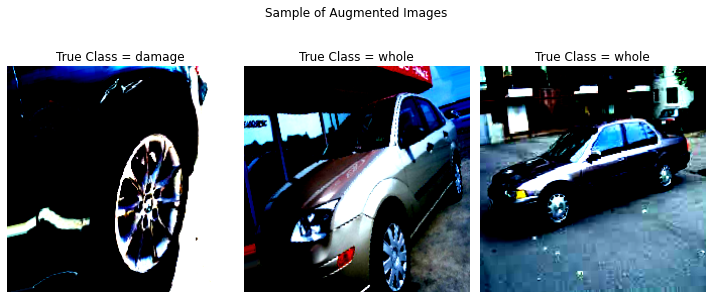

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA1_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(label)]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg16 model and setting layers as non trainable
densenet201 = applications.densenet.DenseNet201(include_top = False, weights = 'imagenet', input_shape=input_shape, pooling=None)

# Setting VGG16 layers to non trainable
for i in range(len(densenet201.layers)):
  densenet201.layers[i].trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(densenet201.output)
X = Dense(units=64, activation='relu')(fc)
# X = Dropout(0.5)(X)
X = Dense(units=32, activation='relu')(X)
# X = Dropout(0.5)(X)
X = Dense(units=16, activation='relu')(X)
# X = Dropout(0.5)(X)
out = Dense(units=1, activation='sigmoid')(X)

densenet201_data1 = Model(inputs = densenet201.input, outputs = out)

densenet201_data1.summary()

74842112/74836368 [==============================] - 8s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________

In [ ]:
# Initializing epochs
epochs=30

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data1/densenet201'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
densenet201_data1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
densenet201_data1_history = densenet201_data1.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 23 steps, validate for 6 steps
Epoch 1/30
23/23 [==============================] - 146s 6s/step - loss: 0.4657 - accuracy: 0.7568 - precision_3: 0.6981 - recall_3: 0.9049 - val_loss: 0.2130 - val_accuracy: 0.9022 - val_precision_3: 0.8776 - val_recall_3: 0.9348
Epoch 2/30
23/23 [==============================] - 123s 5s/step - loss: 0.2411 - accuracy: 0.9062 - precision_3: 0.9284 - recall_3: 0.8804 - val_loss: 0.1856 - val_accuracy: 0.9348 - val_precision_3: 0.9040 - val_recall_3: 0.9728
Epoch 3/30
23/23 [==============================] - 141s 6s/step - loss: 0.1750 - accuracy: 0.9334 - precision_3: 0.9468 - recall_3: 0.9185 - val_loss: 0.1820 - val_accuracy: 0.9348 - val_precision_3: 0.9124 - val_recall_3: 0.9620
Epoch 4/30
23/23 [==============================] - 115s 5s/step - loss: 0.1419 - accuracy: 0.9429 - precision_3: 0.9566 - recall_3: 0.9280 - val_loss: 0.1554 - val_accuracy: 0.9321 - val_precision_3: 0.9649 - val_re

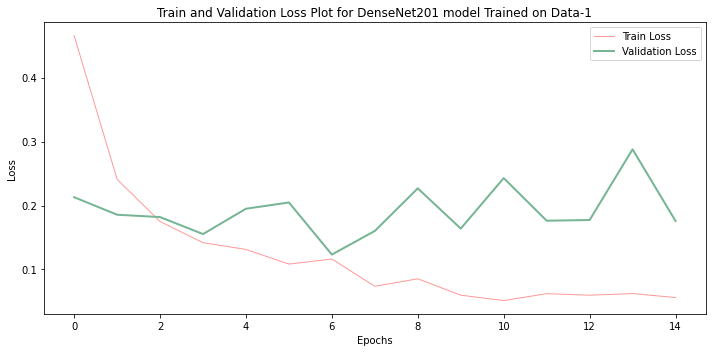

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for DenseNet201 model Trained on Data-1")
plt.plot(densenet201_data1_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data1_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

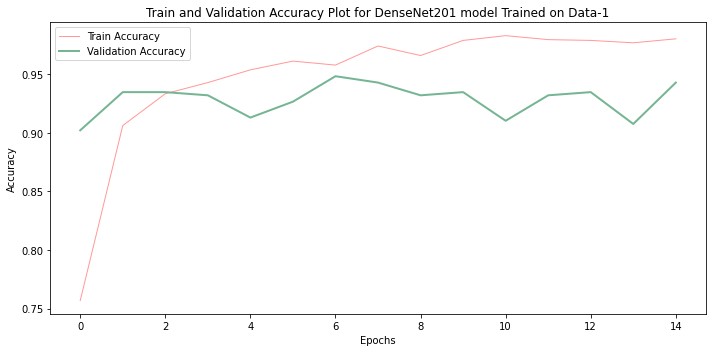

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for DenseNet201 model Trained on Data-1")
plt.plot(densenet201_data1_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data1_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = densenet201_data1.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
8/8 [==============================] - 7s 857ms/step - loss: 0.3185 - accuracy: 0.9217 - precision_4: 0.9450 - recall_4: 0.8957
Test Loss: 0.3185
Test Accuracy: 92.1739 %
Test Precision: 94.4954 %
Test Recall: 89.5652 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


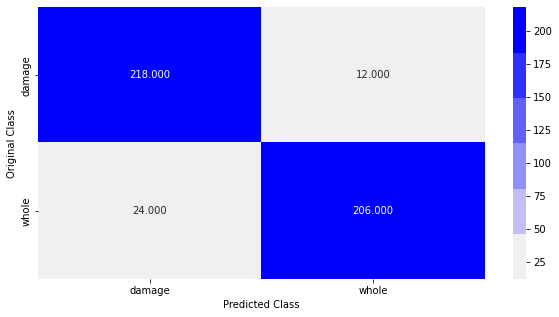

In [ ]:
#Plotting confusion matrix
test_preds_proba = densenet201_data1.predict(test_generator)
test_preds = np.where(test_preds_proba.ravel()>=0.5, 1, 0)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
densenet201_data1.save(checkpoint_filepath+'densenet201_data1.h5')

In [ ]:
np.save(checkpoint_filepath+'densenet201_data1_history.npy', densenet201_data1_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### FEATURE MAPS AND SALIENCY MAPS OF BEST MODEL ON DATA-1

In [ ]:
# Function to generate feature maps

def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(input_image)[0,:,:,:].transpose((2,0,1))

**Best Model is ResNet152**

In [ ]:
# Load the saved model stored at checkpoint_filepath

checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data1/resnet152'

# Recreate the exact same model, including its weights and the optimizer
best_model_data1 = tf.keras.models.load_model(checkpoint_filepath+'resnet152_data1.h5')

In [ ]:
target_size = (224,224)
batch_size = 64

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input)

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=batch_size, shuffle=False)

Found 460 images belonging to 2 classes.


In [ ]:
# Calculating predictions and predictions probabilities for test data

test_preds_proba = best_model_data1.predict(test_generator)
test_preds = np.where(test_preds_proba.ravel()>=0.5, 1, 0)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

#### Test data that was classified correctly by our model

Found 460 images belonging to 2 classes.


Text(0.5, 1.0, 'True Class: damage')

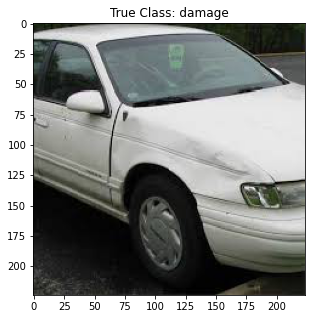

In [ ]:
# Plotting a random image from test data that was classified correctly by our model

idxs = np.argwhere(test_true==test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[int(label[0])]))

Found 460 images belonging to 2 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block1_2_conv' Layer")

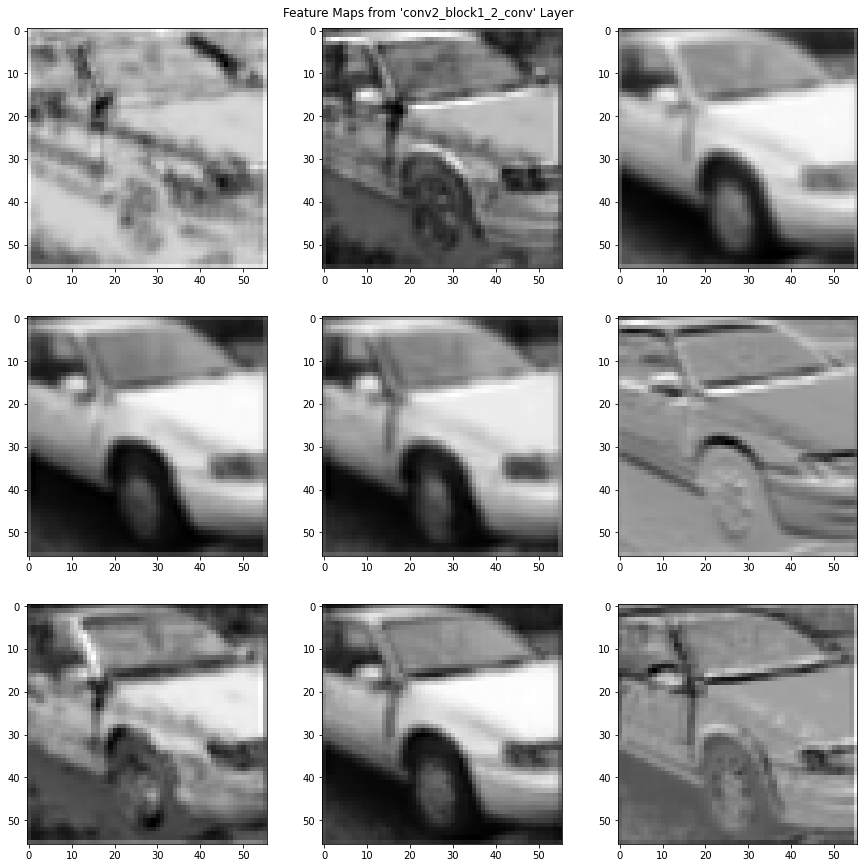

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 10

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data1, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data1.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

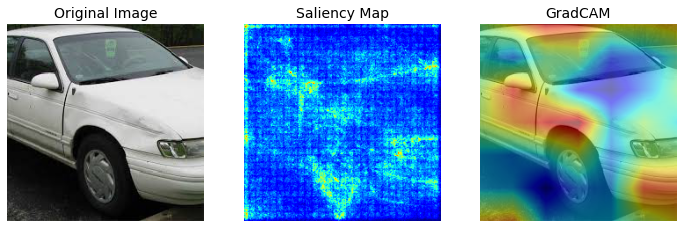

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_true[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data1,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data1,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

#### Test data that was classified incorrectly by our model

Found 460 images belonging to 2 classes.


Text(0.5, 1.0, 'True Class: whole\n Predicted Class: damage')

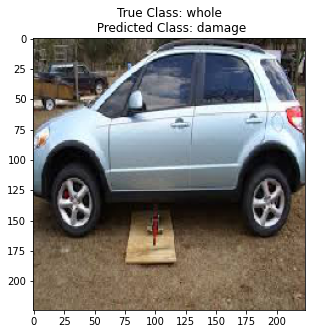

In [ ]:
# Plotting a random image from test data that was classified incorrectly by our model

idxs = np.argwhere(test_true!=test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[int(label[0])])+'\n Predicted Class: '+str(labels_list[int(test_preds[test_img_idx])]))

Found 460 images belonging to 2 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block1_2_conv' Layer")

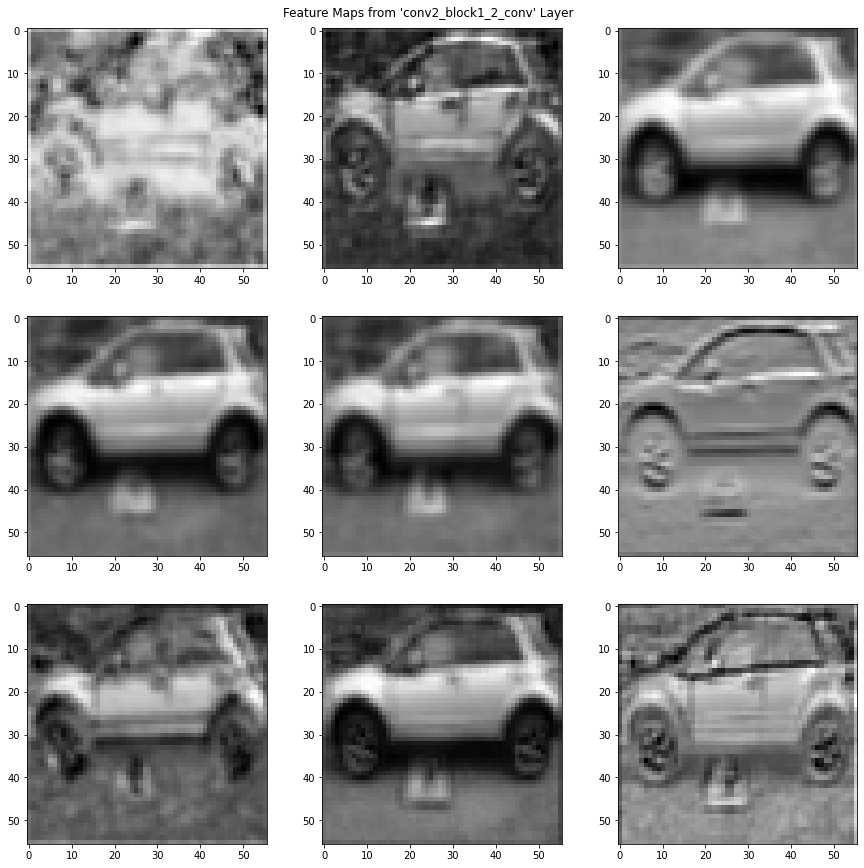

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA1_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='binary', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 10

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data1, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data1.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

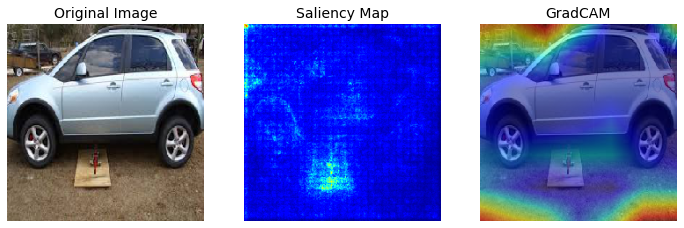

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_preds[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data1,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data1,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

## MODELLING ON DATA - 2

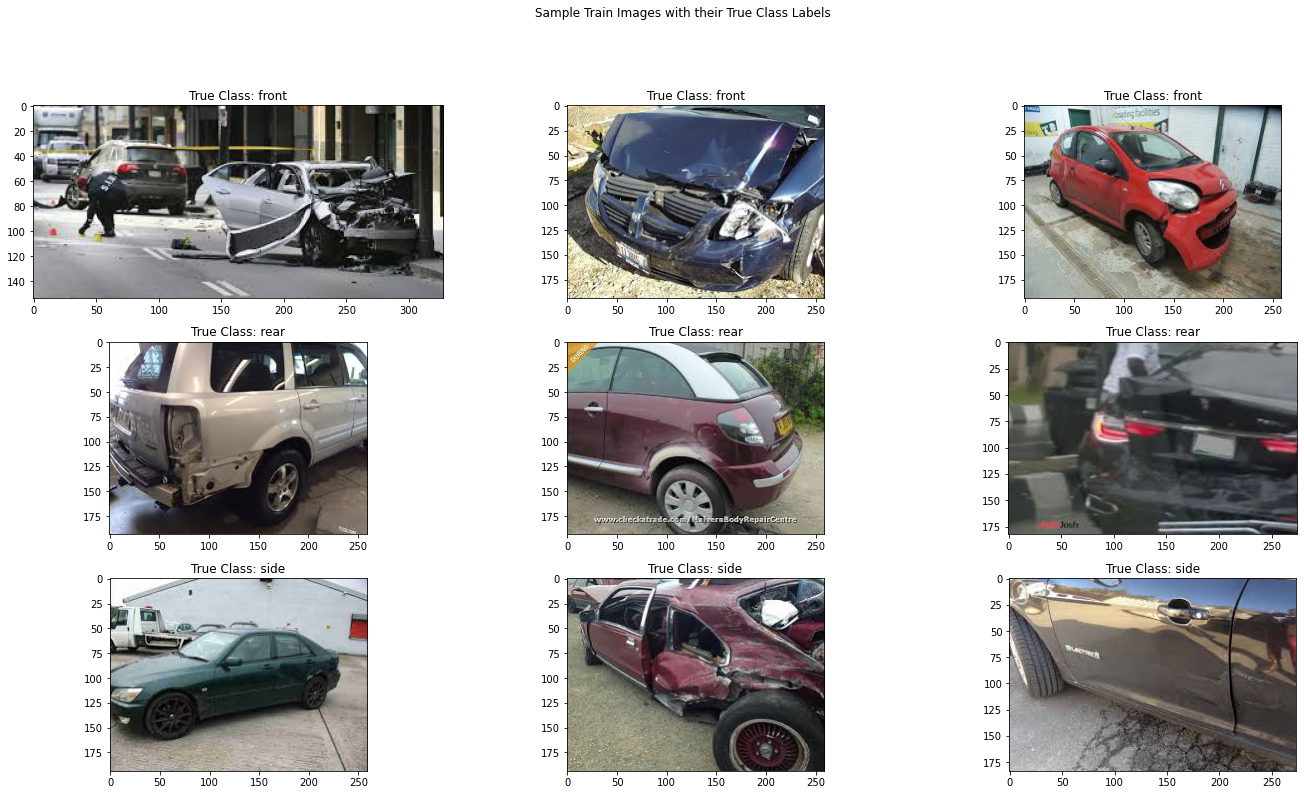

In [ ]:
# Plotting Sample Train Images with their True Class Labels

front_idx = np.random.randint(0, len(train_front), 3)
rear_idx = np.random.randint(0, len(train_rear), 3)
side_idx = np.random.randint(0, len(train_side), 3)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

for i in range(3):
  image = Image.open(TRAIN_FRONT_PATH+'/'+train_front[front_idx[i]])
  image = np.array(image)
  ax[0, i].imshow(image)
  ax[0, i].set_title('True Class: front')

for i in range(3):
  image = Image.open(TRAIN_REAR_PATH+'/'+train_rear[rear_idx[i]])
  image = np.array(image)
  ax[1, i].imshow(image)
  ax[1, i].set_title('True Class: rear')

for i in range(3):
  image = Image.open(TRAIN_SIDE_PATH+'/'+train_side[side_idx[i]])
  image = np.array(image)
  ax[2, i].imshow(image)
  ax[2, i].set_title('True Class: side')
plt.suptitle('Sample Train Images with their True Class Labels', y=1.1)
plt.tight_layout()

### DATA AUGMENTATION

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 789 images belonging to 3 classes.
Found 196 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


Found 789 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


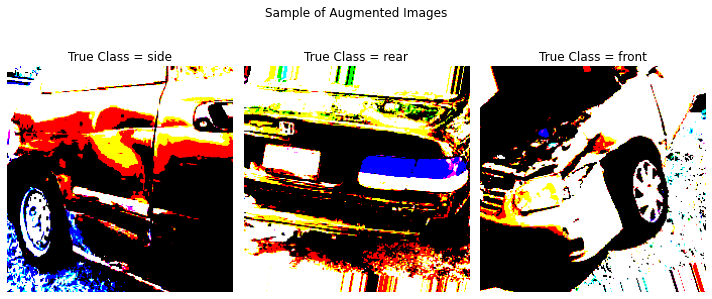

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

### VGG19

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
vgg19 = applications.vgg19.VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(vgg19.layers)):
  vgg19.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(vgg19.output)
X = Dense(units=512, activation='relu')(fc)
X = Dropout(0.2)(X)
X = Dense(units=256, activation='relu')(X)
# X = Dropout(0.1)(X)
X = Dense(units=128, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

vgg19_data2 = Model(inputs = vgg19.input, outputs = out)

vgg19_data2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/vgg19'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
vgg19_data2.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
vgg19_data2_history = vgg19_data2.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
13/13 [==============================] - 23s 2s/step - loss: 19.4160 - accuracy: 0.3992 - precision_5: 0.3992 - recall_5: 0.3992 - val_loss: 3.6708 - val_accuracy: 0.4745 - val_precision_5: 0.4745 - val_recall_5: 0.4745
Epoch 2/30
13/13 [==============================] - 19s 1s/step - loss: 5.1369 - accuracy: 0.5564 - precision_5: 0.5580 - recall_5: 0.5551 - val_loss: 5.4724 - val_accuracy: 0.6122 - val_precision_5: 0.6154 - val_recall_5: 0.6122
Epoch 3/30
13/13 [==============================] - 21s 2s/step - loss: 3.3724 - accuracy: 0.6641 - precision_5: 0.6645 - recall_5: 0.6629 - val_loss: 1.6375 - val_accuracy: 0.6990 - val_precision_5: 0.6974 - val_recall_5: 0.6939
Epoch 4/30
13/13 [==============================] - 22s 2s/step - loss: 1.6092 - accuracy: 0.7250 - precision_5: 0.7270 - recall_5: 0.7224 - val_loss: 1.5480 - val_accuracy: 0.6480 - val_precision_5: 0.6462 - val_recal

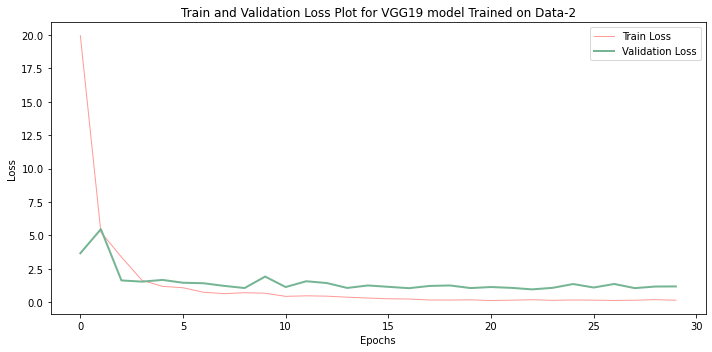

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for VGG19 model Trained on Data-2")
plt.plot(vgg19_data2_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data2_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

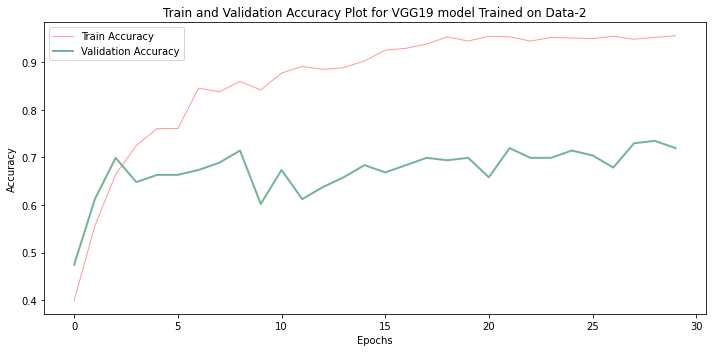

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for VGG19 model Trained on Data-2")
plt.plot(vgg19_data2_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data2_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = vgg19_data2.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 3s 868ms/step - loss: 1.1949 - accuracy: 0.7207 - precision_5: 0.7247 - recall_5: 0.7207
Test Loss: 1.1949
Test Accuracy: 72.0670 %
Test Precision: 72.4719 %
Test Recall: 72.0670 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


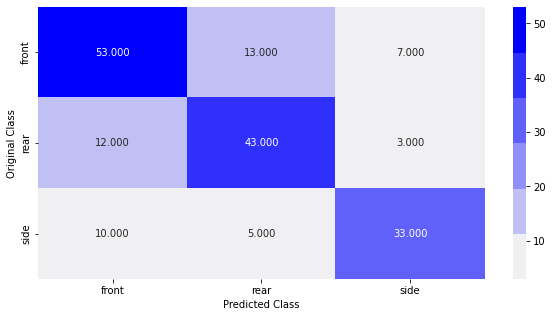

In [ ]:
#Plotting confusion matrix
test_preds_proba = vgg19_data2.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
vgg19_data2.save(checkpoint_filepath+'vgg19_data2.h5')

In [ ]:
np.save(checkpoint_filepath+'vgg19_data2_history.npy', vgg19_data2_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### ResNet152

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 789 images belonging to 3 classes.
Found 196 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 789 images belonging to 3 classes.


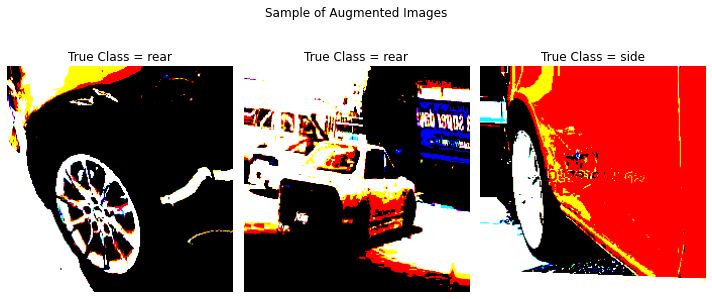

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
resnet152 = applications.resnet.ResNet152(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(resnet152.layers)):
  resnet152.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(resnet152.output)
X = Dense(units=128, activation='relu')(fc)
# X = Dropout(0.1)(X)
X = Dense(units=64, activation='relu')(X)
# X = Dropout(0.1)(X)
X = Dense(units=32, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

resnet152_data2 = Model(inputs = resnet152.input, outputs = out)

resnet152_data2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/resnet152'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
resnet152_data2.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
resnet152_data2_history = resnet152_data2.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
13/13 [==============================] - 96s 7s/step - loss: 5.1062 - accuracy: 0.3587 - precision_3: 0.3613 - recall_3: 0.3498 - val_loss: 2.2973 - val_accuracy: 0.4031 - val_precision_3: 0.4115 - val_recall_3: 0.4031
Epoch 2/30
13/13 [==============================] - 82s 6s/step - loss: 1.6333 - accuracy: 0.6046 - precision_3: 0.6088 - recall_3: 0.5957 - val_loss: 1.8519 - val_accuracy: 0.6276 - val_precision_3: 0.6302 - val_recall_3: 0.6173
Epoch 3/30
13/13 [==============================] - 86s 7s/step - loss: 0.9289 - accuracy: 0.7402 - precision_3: 0.7481 - recall_3: 0.7338 - val_loss: 1.0027 - val_accuracy: 0.7041 - val_precision_3: 0.7047 - val_recall_3: 0.6939
Epoch 4/30
13/13 [==============================] - 23s 2s/step - loss: 0.5095 - accuracy: 0.8416 - precision_3: 0.8451 - recall_3: 0.8365 - val_loss: 1.3121 - val_accuracy: 0.6276 - val_precision_3: 0.6406 - val_recall

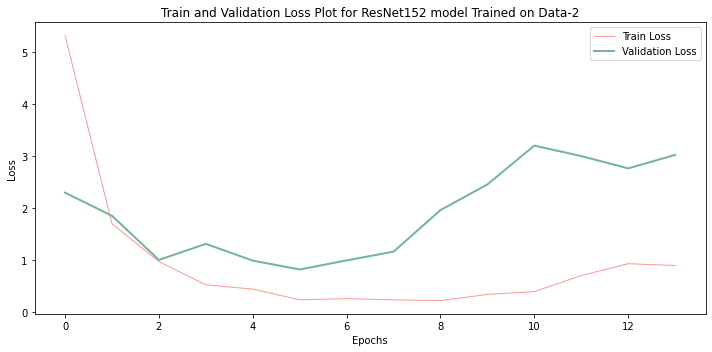

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for ResNet152 model Trained on Data-2")
plt.plot(resnet152_data2_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data2_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

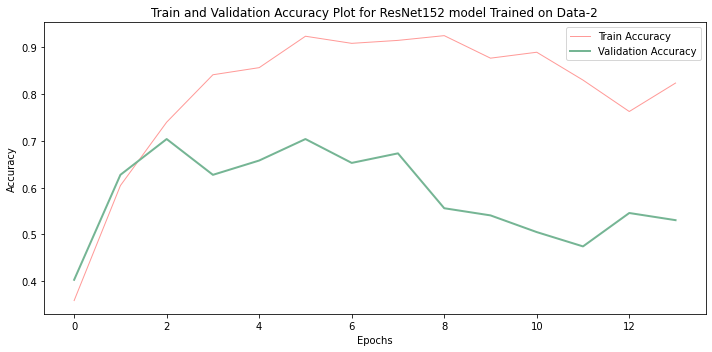

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for ResNet152 model Trained on Data-2")
plt.plot(resnet152_data2_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data2_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = resnet152_data2.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 7s 2s/step - loss: 0.9441 - accuracy: 0.7318 - precision_3: 0.7514 - recall_3: 0.7263
Test Loss: 0.9441
Test Accuracy: 73.1844 %
Test Precision: 75.1445 %
Test Recall: 72.6257 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


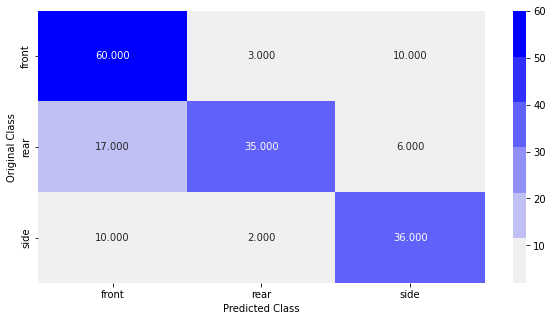

In [ ]:
#Plotting confusion matrix
test_preds_proba = resnet152_data2.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
resnet152_data2.save(checkpoint_filepath+'resnet152_data2.h5')

In [ ]:
np.save(checkpoint_filepath+'resnet152_data2_history.npy', resnet152_data2_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### DenseNet201

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 789 images belonging to 3 classes.
Found 196 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 789 images belonging to 3 classes.


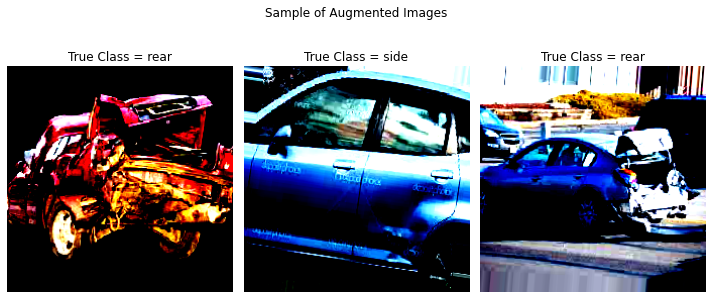

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA2_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
densenet201 = applications.densenet.DenseNet201(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(densenet201.layers)):
  densenet201.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(densenet201.output)
X = Dense(units=128, activation='relu')(fc)
# X = Dropout(0.2)(X)
X = Dense(units=64, activation='relu')(X)
# X = Dropout(0.1)(X)
X = Dense(units=32, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

densenet201_data2 = Model(inputs = densenet201.input, outputs = out)

densenet201_data2.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/densenet201'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
densenet201_data2.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
densenet201_data2_history = densenet201_data2.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
13/13 [==============================] - 109s 8s/step - loss: 3.9054 - accuracy: 0.3777 - precision_9: 0.3879 - recall_9: 0.3485 - val_loss: 0.8547 - val_accuracy: 0.6173 - val_precision_9: 0.6824 - val_recall_9: 0.5153
Epoch 2/30
13/13 [==============================] - 96s 7s/step - loss: 0.8061 - accuracy: 0.6515 - precision_9: 0.6771 - recall_9: 0.5767 - val_loss: 0.8032 - val_accuracy: 0.6020 - val_precision_9: 0.6310 - val_recall_9: 0.5408
Epoch 3/30
13/13 [==============================] - 95s 7s/step - loss: 0.5440 - accuracy: 0.7592 - precision_9: 0.7844 - recall_9: 0.7376 - val_loss: 0.7819 - val_accuracy: 0.6735 - val_precision_9: 0.6932 - val_recall_9: 0.6224
Epoch 4/30
13/13 [==============================] - 19s 1s/step - loss: 0.4404 - accuracy: 0.8327 - precision_9: 0.8468 - recall_9: 0.8124 - val_loss: 0.8782 - val_accuracy: 0.5918 - val_precision_9: 0.6201 - val_recal

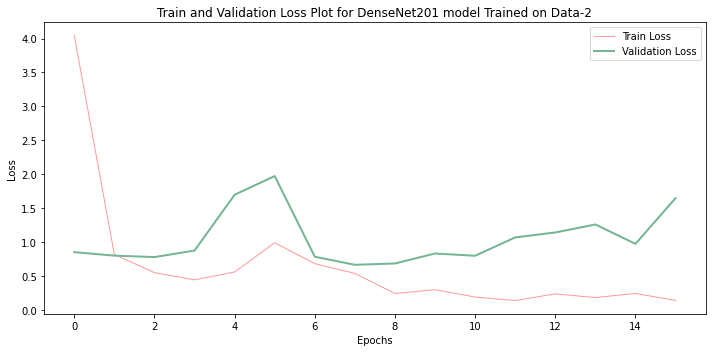

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for DenseNet201 model Trained on Data-2")
plt.plot(densenet201_data2_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data2_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

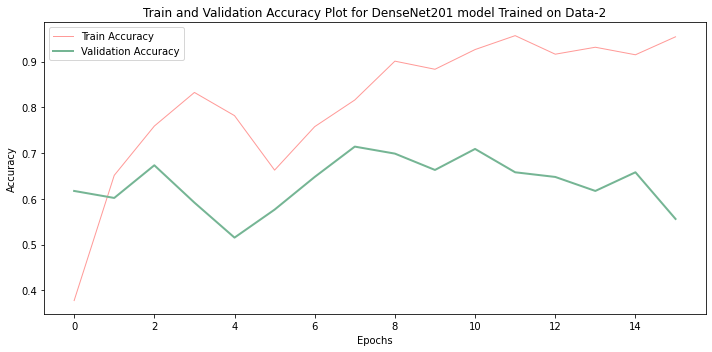

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for DenseNet201 model Trained on Data-2")
plt.plot(densenet201_data2_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data2_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = densenet201_data2.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 6s 2s/step - loss: 0.8387 - accuracy: 0.7207 - precision_9: 0.7283 - recall_9: 0.7039
Test Loss: 0.8387
Test Accuracy: 72.0670 %
Test Precision: 72.8324 %
Test Recall: 70.3911 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


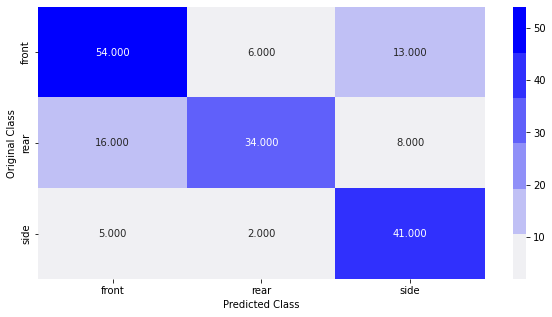

In [ ]:
#Plotting confusion matrix
test_preds_proba = densenet201_data2.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
densenet201_data2.save(checkpoint_filepath+'densenet201_data2.h5')

In [ ]:
np.save(checkpoint_filepath+'densenet201_data2_history.npy', densenet201_data2_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

**Saving a dictionary to a file in python**

https://www.kite.com/python/answers/how-to-save-a-dictionary-to-a-file-in-python

In [ ]:
# Saving the dictionary that contains class mapping
CLASS_DICTIONARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/'

dictionary_data = train_generator.class_indices

a_file = open(CLASS_DICTIONARY_PATH+"class_map.json", "w")
json.dump(dictionary_data, a_file)
a_file.close()

# a_file = open(CLASS_DICTIONARY_PATH+"class_map.json", "r")
# output = a_file.read()
# print(output)
# a_file.close()

### FEATURE MAPS AND SALIENCY MAPS OF BEST MODEL ON DATA-2

In [ ]:
# Function to generate feature maps

def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(input_image)[0,:,:,:].transpose((2,0,1))

**Best Model is ResNet152**

In [ ]:
# Load the saved model stored at checkpoint_filepath

checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/resnet152'

# Recreate the exact same model, including its weights and the optimizer
best_model_data2 = tf.keras.models.load_model(checkpoint_filepath+'resnet152_data2.h5')

In [ ]:
target_size = (224,224)
batch_size = 64

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input)

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 179 images belonging to 3 classes.


In [ ]:
# Calculating predictions and predictions probabilities for test data

test_preds_proba = best_model_data2.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

#### Test data that was classified correctly by our model

Found 179 images belonging to 3 classes.


Text(0.5, 1.0, 'True Class: rear')

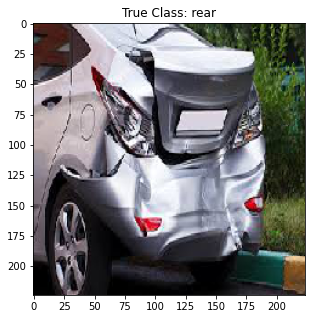

In [ ]:
# Plotting a random image from test data that was classified correctly by our model

idxs = np.argwhere(test_true==test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[np.argmax(label, axis=1)[0]]))

Found 179 images belonging to 3 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block1_2_conv' Layer")

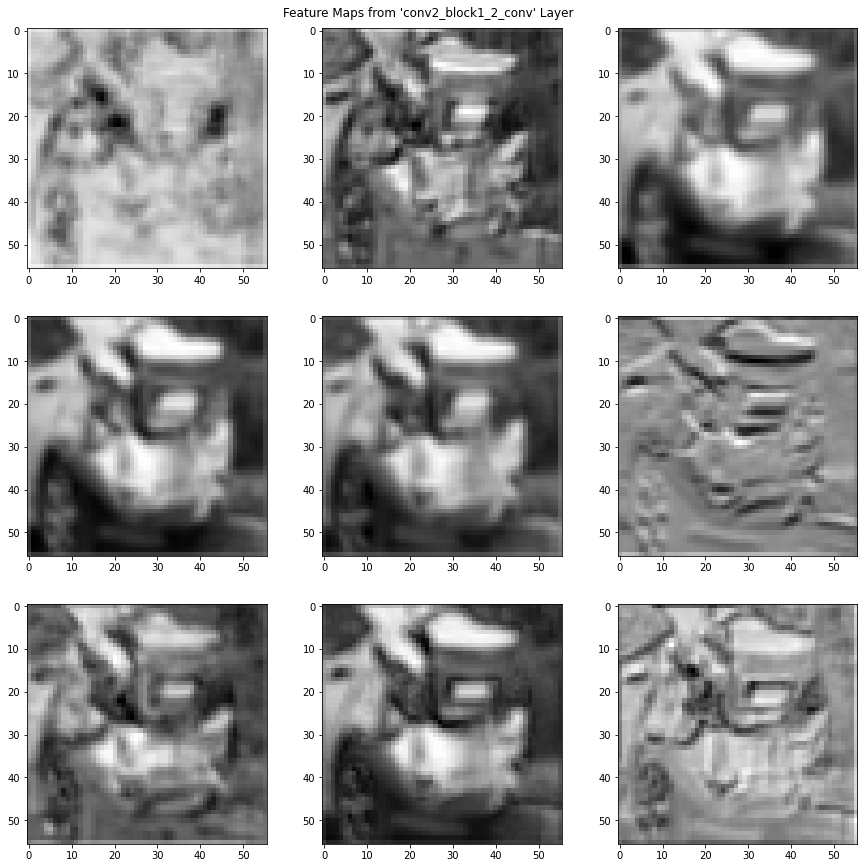

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 10

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data2, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data2.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

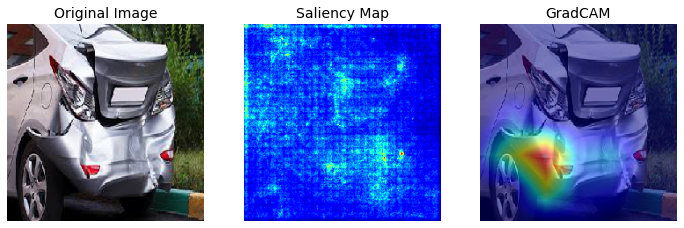

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_true[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data2,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data2,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

#### Test data that was classified incorrectly by our model

Found 179 images belonging to 3 classes.


Text(0.5, 1.0, 'True Class: rear\n Predicted Class: side')

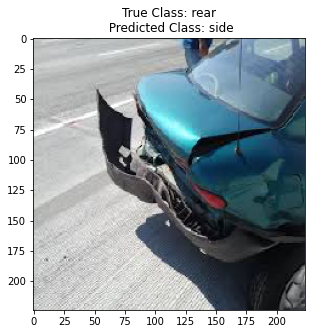

In [ ]:
# Plotting a random image from test data that was classified incorrectly by our model

idxs = np.argwhere(test_true!=test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[np.argmax(label, axis=1)[0]])+'\n Predicted Class: '+str(labels_list[int(test_preds[test_img_idx])]))

Found 179 images belonging to 3 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block1_2_conv' Layer")

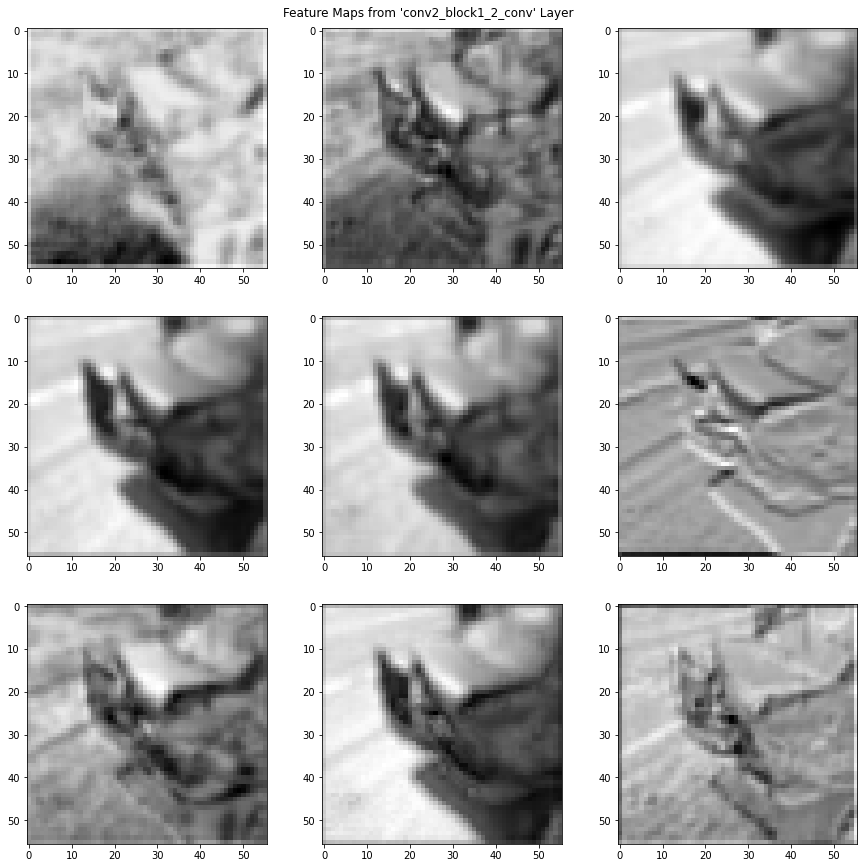

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA2_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 10

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data2, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data2.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

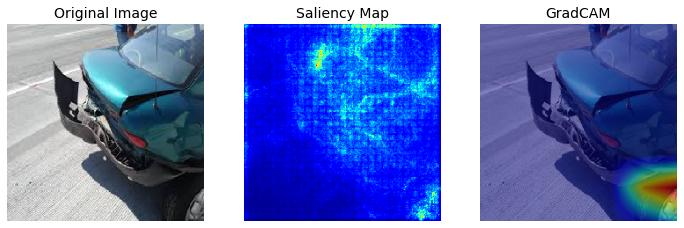

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_preds[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data2,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data2,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

## MODELLING ON DATA - 3

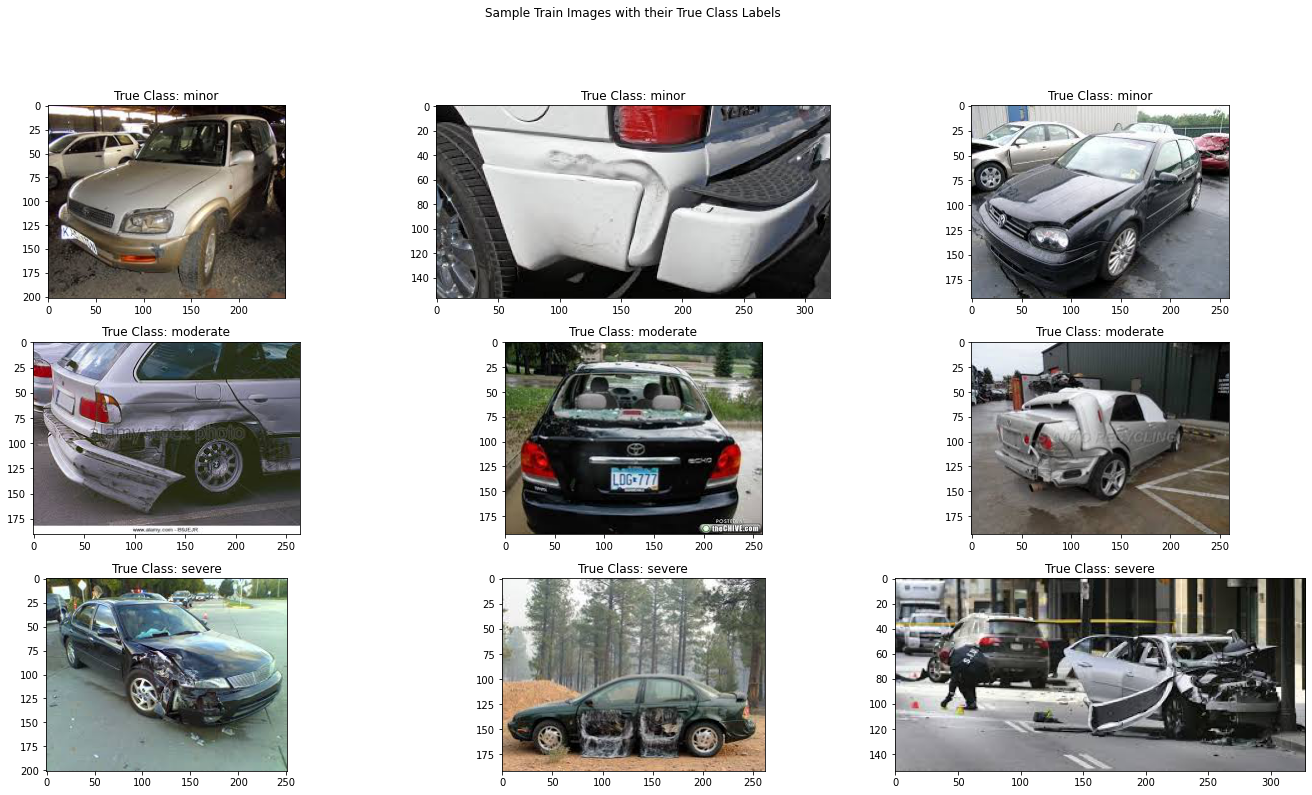

In [ ]:
# Plotting Sample Train Images with their True Class Labels

minor_idx = np.random.randint(0, len(train_minor), 3)
moderate_idx = np.random.randint(0, len(train_moderate), 3)
severe_idx = np.random.randint(0, len(train_severe), 3)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

for i in range(3):
  image = Image.open(TRAIN_MINOR_PATH+'/'+train_minor[minor_idx[i]])
  image = np.array(image)
  ax[0, i].imshow(image)
  ax[0, i].set_title('True Class: minor')

for i in range(3):
  image = Image.open(TRAIN_MODERATE_PATH+'/'+train_moderate[moderate_idx[i]])
  image = np.array(image)
  ax[1, i].imshow(image)
  ax[1, i].set_title('True Class: moderate')

for i in range(3):
  image = Image.open(TRAIN_SEVERE_PATH+'/'+train_severe[severe_idx[i]])
  image = np.array(image)
  ax[2, i].imshow(image)
  ax[2, i].set_title('True Class: severe')
plt.suptitle('Sample Train Images with their True Class Labels', y=1.1)
plt.tight_layout()

### DATA AUGMENTATION

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.vgg19.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 784 images belonging to 3 classes.
Found 195 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


Found 784 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


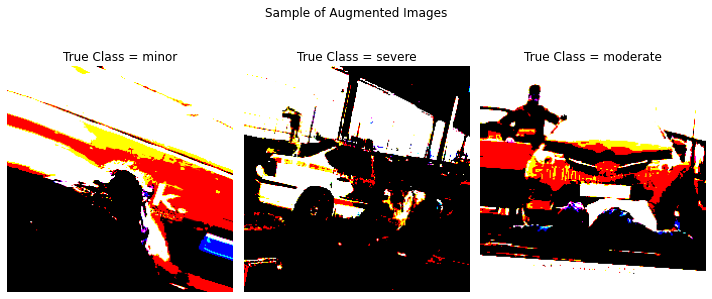

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

### VGG19

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
vgg19 = applications.vgg19.VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(vgg19.layers)):
  vgg19.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(vgg19.output)
X = Dense(units=512, activation='relu')(fc)
X = Dropout(0.2)(X)
X = Dense(units=256, activation='relu')(X)
X = Dropout(0.2)(X)
X = Dense(units=128, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

vgg19_data3 = Model(inputs = vgg19.input, outputs = out)

vgg19_data3.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/vgg19'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
vgg19_data3.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
vgg19_data3_history = vgg19_data3.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
13/13 [==============================] - 23s 2s/step - loss: 13.6159 - accuracy: 0.3967 - precision_11: 0.3967 - recall_11: 0.3967 - val_loss: 3.2208 - val_accuracy: 0.5538 - val_precision_11: 0.5567 - val_recall_11: 0.5538
Epoch 2/30
13/13 [==============================] - 22s 2s/step - loss: 5.5551 - accuracy: 0.4923 - precision_11: 0.4949 - recall_11: 0.4923 - val_loss: 1.9593 - val_accuracy: 0.6000 - val_precision_11: 0.6010 - val_recall_11: 0.5949
Epoch 3/30
13/13 [==============================] - 22s 2s/step - loss: 3.5431 - accuracy: 0.5676 - precision_11: 0.5685 - recall_11: 0.5663 - val_loss: 1.8836 - val_accuracy: 0.6051 - val_precision_11: 0.6126 - val_recall_11: 0.6000
Epoch 4/30
13/13 [==============================] - 22s 2s/step - loss: 2.3965 - accuracy: 0.5995 - precision_11: 0.5995 - recall_11: 0.5918 - val_loss: 1.2223 - val_accuracy: 0.6513 - val_precision_11: 0.6

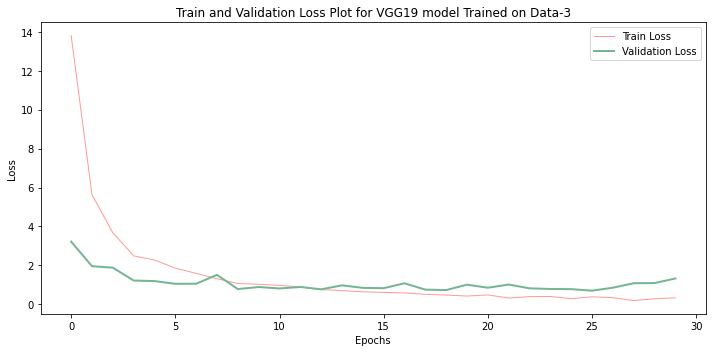

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for VGG19 model Trained on Data-3")
plt.plot(vgg19_data3_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data3_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

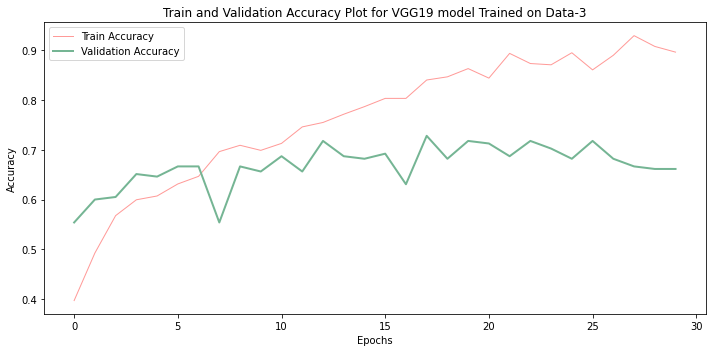

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for VGG19 model Trained on Data-3")
plt.plot(vgg19_data3_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(vgg19_data3_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# Load the saved model stored at checkpoint_filepath

checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/vgg19'

# Recreate the exact same model, including its weights and the optimizer
vgg19_data3 = tf.keras.models.load_model(checkpoint_filepath+'vgg19_data3.h5')

# Show the model architecture
vgg19_data3.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = vgg19_data3.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 3s 895ms/step - loss: 1.4035 - accuracy: 0.6725 - precision_11: 0.6765 - recall_11: 0.6725
Test Loss: 1.4035
Test Accuracy: 67.2515 %
Test Precision: 67.6471 %
Test Recall: 67.2515 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


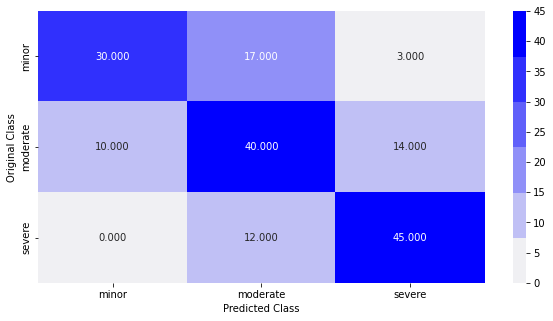

In [ ]:
#Plotting confusion matrix
test_preds_proba = vgg19_data3.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
vgg19_data3.save(checkpoint_filepath+'vgg19_data3.h5')

In [ ]:
np.save(checkpoint_filepath+'vgg19_data3_history.npy', vgg19_data3_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### ResNet152

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.resnet50.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 784 images belonging to 3 classes.
Found 195 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


Found 784 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


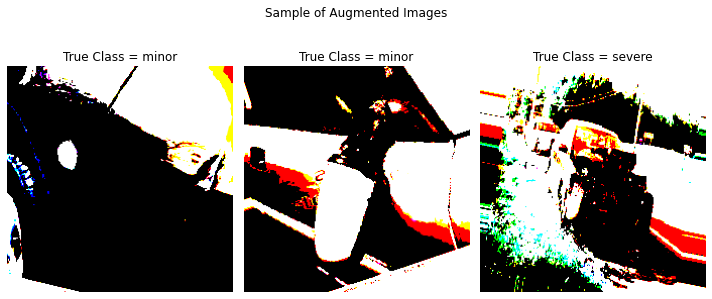

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
resnet152 = applications.resnet.ResNet152(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(resnet152.layers)):
  resnet152.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(resnet152.output)
X = Dense(units=256, activation='relu')(fc)
X = Dropout(0.3)(X)
X = Dense(units=256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(units=128, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

resnet152_data3 = Model(inputs = resnet152.input, outputs = out)

resnet152_data3.summary()

234700800/234698864 [==============================] - 10s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/resnet152'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
resnet152_data3.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
resnet152_data3_history = resnet152_data3.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
12/13 [==========================>...] - ETA: 20s - loss: 7.4555 - accuracy: 0.3685 - precision: 0.3687 - recall: 0.3620WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/resnet152/assets
13/13 [==============================] - 376s 29s/step - loss: 7.2884 - accuracy: 0.3661 - precision: 0.3662 - recall: 0.3597 - val_loss: 1.7024 - val_accuracy: 0.6000 - val_precision: 0.6064 - val_recall: 0.5846
Epoch 2/30
13/13 [==============================] - 84s 6s/step

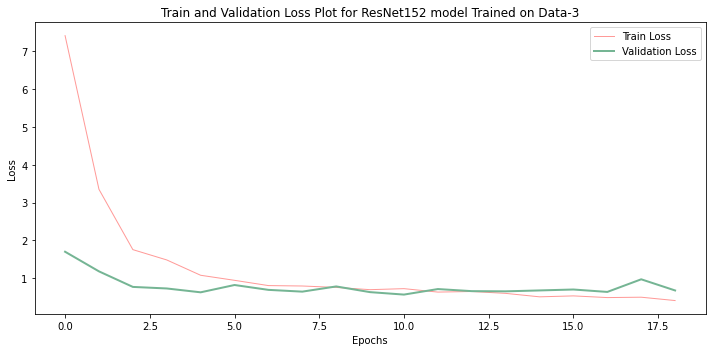

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for ResNet152 model Trained on Data-3")
plt.plot(resnet152_data3_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data3_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

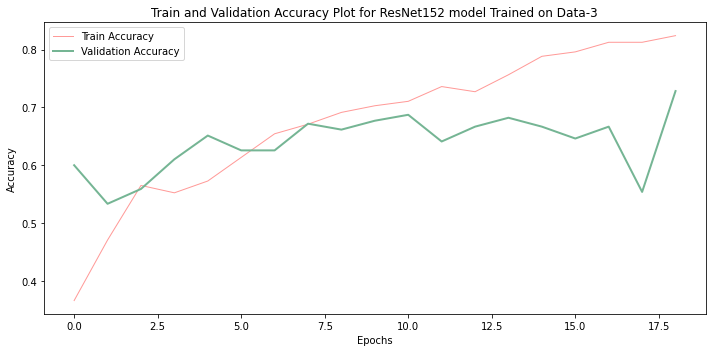

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for ResNet152 model Trained on Data-3")
plt.plot(resnet152_data3_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(resnet152_data3_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = resnet152_data3.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 53s 18s/step - loss: 0.7377 - accuracy: 0.6784 - precision: 0.7368 - recall: 0.5731
Test Loss: 0.7377
Test Accuracy: 67.8363 %
Test Precision: 73.6842 %
Test Recall: 57.3099 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


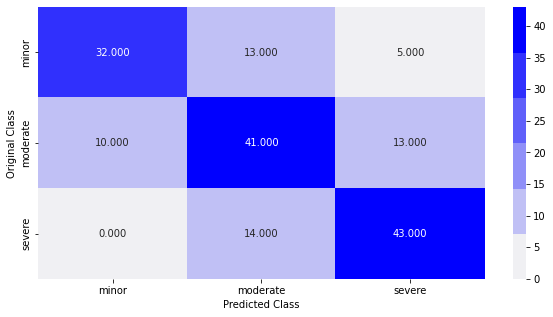

In [ ]:
#Plotting confusion matrix
test_preds_proba = resnet152_data3.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
resnet152_data3.save(checkpoint_filepath+'resnet152_data3.h5')

In [ ]:
np.save(checkpoint_filepath+'resnet152_data3_history.npy', resnet152_data3_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

### DenseNet201

In [ ]:
# Initializing batch size
batch_size = 64

# Initializing target size
target_size = (224,224)

# Initialise an image generator object for train data
train_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input,
    rotation_range=20,
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input)

# Read the train image data using the train generator object
train_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

# Read the validation image data using the train generator object
val_generator = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 784 images belonging to 3 classes.
Found 195 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 784 images belonging to 3 classes.


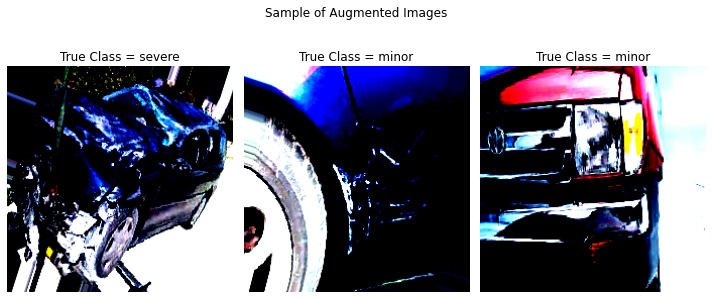

In [ ]:
# Plotting a sample of the generated images

# iterator
aug_iter = train_datagen.flow_from_directory(DATA3_TRAIN_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=True, subset='training')

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax = ax.ravel()
# generate batch of images
for i in range(3):

  # Get the next image and its label
  image, label = next(aug_iter)
  class_name = list(aug_iter.class_indices.keys())[int(np.argmax(label))]
  
  # plot image
  ax[i].imshow(np.squeeze(image, axis=(0)))
  ax[i].set_title('True Class = '+str(class_name))
  ax[i].axis('off')
plt.suptitle('Sample of Augmented Images')
plt.tight_layout()

In [ ]:
# Initializing input shape
input_shape = (224, 224, 3)

#Importing vgg19 model and setting layers as non trainable
densenet201 = applications.densenet.DenseNet201(include_top = False, weights = 'imagenet', input_shape=input_shape)

# Setting VGG19 layers to non trainable
for i in range(len(densenet201.layers)):
  densenet201.layers[i].trainable = False
# for layer in vgg19.layers[-3:]:
#   layer.trainable = True
# for layer in vgg19.layers[:-3]:
#   layer.trainable = False

# Adding Dense layers that will be fine-tuned for our dataset
fc = Flatten()(densenet201.output)
X = Dense(units=256, activation='relu')(fc)
X = Dropout(0.3)(X)
X = Dense(units=256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(units=128, activation='relu')(X)
# X = Dropout(0.1)(X)
out = Dense(units=3, activation='softmax')(X)

densenet201_data3 = Model(inputs = densenet201.input, outputs = out)

densenet201_data3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Initializing epochs
epochs=30

# Calculating appropriate class weights as the data is slightly imbalanced 
class_weight = dict(zip(train_generator.class_indices.values(), compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.labels), y=train_generator.labels)))

# Use keras ModelCheckpoint to keep saving the model progress
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/densenet201'

check_point = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    save_freq="epoch")

# Use the keras early stopping callback with patience=8
# while monitoring the loss
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

# Compile the model with accuracy as the metric and adam optimizer
densenet201_data3.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

# Train the model
densenet201_data3_history = densenet201_data3.fit(
        train_generator,
        epochs=epochs, shuffle=False, workers=-1,
        validation_data=val_generator,
        callbacks=[early_stop, check_point],
        class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 4 steps
Epoch 1/30
13/13 [==============================] - 110s 8s/step - loss: 5.7443 - accuracy: 0.3686 - precision_2: 0.3691 - recall_2: 0.3597 - val_loss: 0.9437 - val_accuracy: 0.5744 - val_precision_2: 0.6111 - val_recall_2: 0.5641
Epoch 2/30
13/13 [==============================] - 20s 2s/step - loss: 2.4297 - accuracy: 0.4043 - precision_2: 0.4062 - recall_2: 0.3814 - val_loss: 0.9515 - val_accuracy: 0.4718 - val_precision_2: 0.5714 - val_recall_2: 0.3692
Epoch 3/30
13/13 [==============================] - 97s 7s/step - loss: 1.2192 - accuracy: 0.4758 - precision_2: 0.4969 - recall_2: 0.4145 - val_loss: 0.7403 - val_accuracy: 0.6769 - val_precision_2: 0.8246 - val_recall_2: 0.4821
Epoch 4/30
13/13 [==============================] - 19s 1s/step - loss: 0.9658 - accuracy: 0.5395 - precision_2: 0.6087 - recall_2: 0.3571 - val_loss: 0.7952 - val_accuracy: 0.5333 - val_precision_2: 0.6094 - val_recal

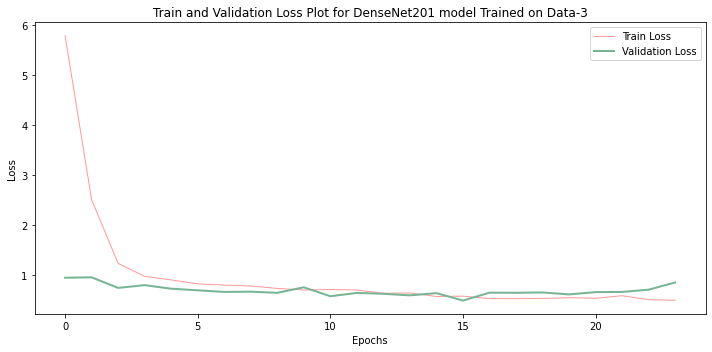

In [ ]:
# plot train and val loss as  a function of epochs
# your code here

# Plot the Loss of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Loss Plot for DenseNet201 model Trained on Data-3")
plt.plot(densenet201_data3_history.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data3_history.history['val_loss'],  label='Validation Loss', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

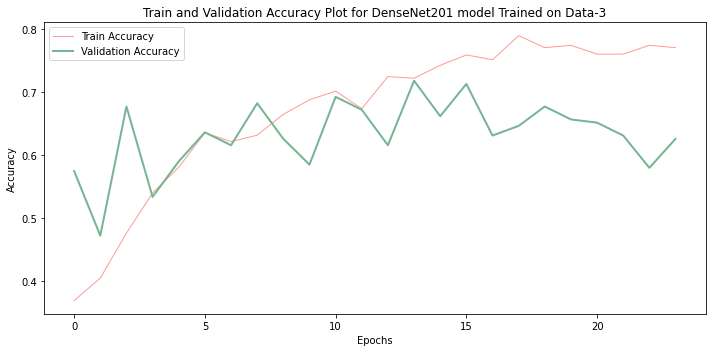

In [ ]:
# plot train and val acc as  a function of epochs
# your code here

# Plot the Accuracy of the model
plt.rcParams["figure.figsize"] = (10,5)
plt.title("Train and Validation Accuracy Plot for DenseNet201 model Trained on Data-3")
plt.plot(densenet201_data3_history.history['accuracy'], label='Train Accuracy', color='#FF9A98', linewidth=1)
plt.plot(densenet201_data3_history.history['val_accuracy'],  label='Validation Accuracy', color='#75B594', linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# evaluating the model on the test data
test_loss, test_acc, test_precision, test_recall = densenet201_data3.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {100*test_acc:.4f} %')
print(f'Test Precision: {100*test_precision:.4f} %')
print(f'Test Recall: {100*test_recall:.4f} %')

  ...
    to  
  ['...']
3/3 [==============================] - 6s 2s/step - loss: 0.6444 - accuracy: 0.7135 - precision_2: 0.7029 - recall_2: 0.5673
Test Loss: 0.6444
Test Accuracy: 71.3450 %
Test Precision: 70.2899 %
Test Recall: 56.7251 %


-------------------------------------------------- Confusion matrix --------------------------------------------------


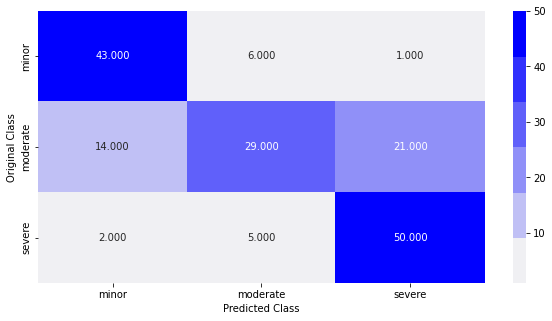

In [ ]:
#Plotting confusion matrix
test_preds_proba = densenet201_data3.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

Cm = confusion_matrix(test_true, test_preds)
print("-"*50, "Confusion matrix", "-"*50)
cmap=sns.light_palette("blue")
plt.figure(figsize=(10,5))
sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
# save the trained model in .h5 format at checkpoint_filepath
densenet201_data3.save(checkpoint_filepath+'densenet201_data3.h5')

In [ ]:
np.save(checkpoint_filepath+'densenet201_data3_history.npy', densenet201_data3_history.history)
 
# history1 = np.load('vgg16_data1_history.npy', allow_pickle='TRUE').item()

In [ ]:
# Saving the dictionary that contains class mapping
CLASS_DICTIONARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/'

dictionary_data = train_generator.class_indices

a_file = open(CLASS_DICTIONARY_PATH+"class_map.json", "w")
json.dump(dictionary_data, a_file)
a_file.close()

# a_file = open(CLASS_DICTIONARY_PATH+"class_map.json", "r")
# output = a_file.read()
# print(output)
# a_file.close()

### FEATURE MAPS AND SALIENCY MAPS OF BEST MODEL ON DATA-3

In [ ]:
# Function to generate feature maps

def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(input_image)[0,:,:,:].transpose((2,0,1))

**Best Model is DenseNet201**

In [ ]:
# Load the saved model stored at checkpoint_filepath

checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/densenet201'

# Recreate the exact same model, including its weights and the optimizer
best_model_data3 = tf.keras.models.load_model(checkpoint_filepath+'densenet201_data3.h5')

In [ ]:
target_size = (224,224)
batch_size = 64

# Initialise an image generator object for test data
test_datagen = ImageDataGenerator(
    preprocessing_function=applications.densenet.preprocess_input)

# Read the test image data using the test generator object
test_generator = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 171 images belonging to 3 classes.


In [ ]:
# Calculating predictions and predictions probabilities for test data

test_preds_proba = best_model_data3.predict(test_generator)
test_preds = np.argmax(test_preds_proba, axis=1)
test_true = test_generator.labels
labels_list = list(test_generator.class_indices.keys())

#### Test data that was classified correctly by our model

Found 171 images belonging to 3 classes.


Text(0.5, 1.0, 'True Class: severe')

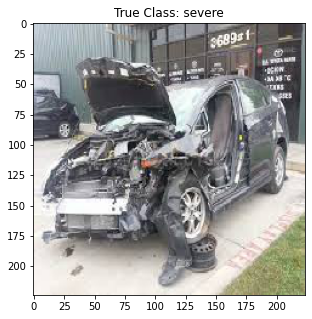

In [ ]:
# Plotting a random image from test data that was classified correctly by our model

idxs = np.argwhere(test_true==test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[np.argmax(label, axis=1)[0]]))

Found 171 images belonging to 3 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block2_concat' Layer")

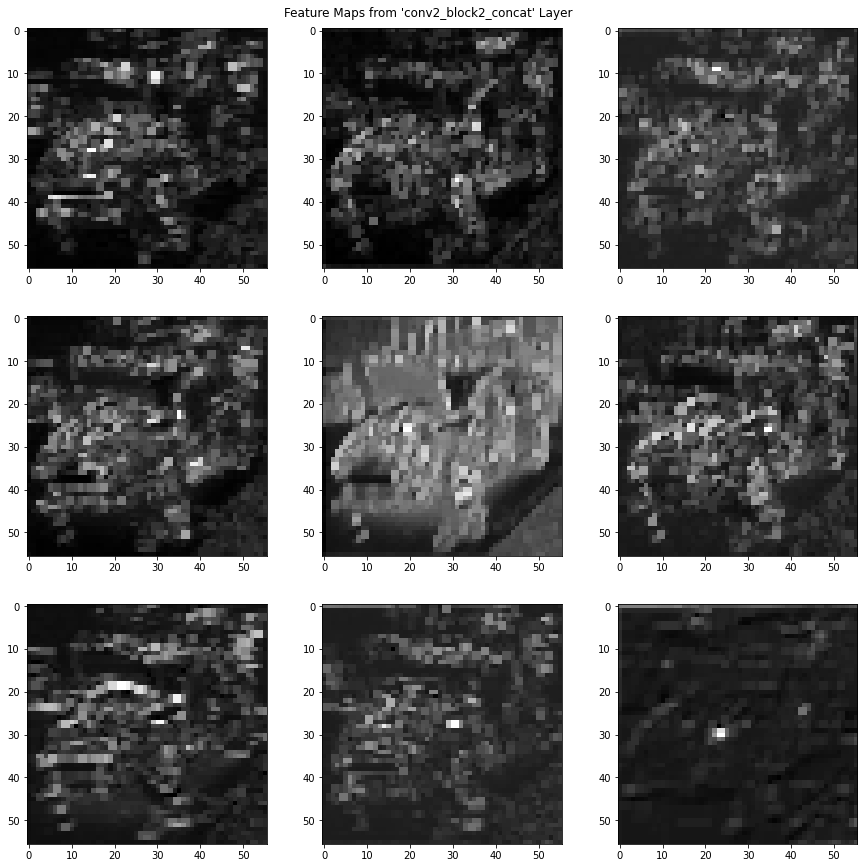

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 20

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data3, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data3.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

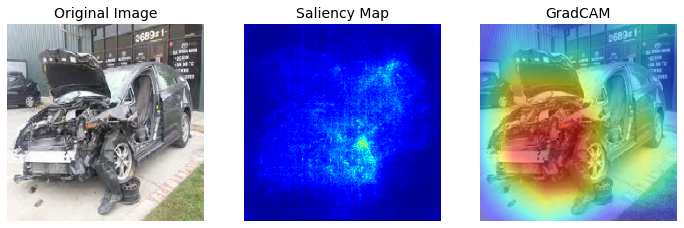

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_true[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data3,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data3,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

#### Test data that was classified incorrectly by our model

Found 171 images belonging to 3 classes.


Text(0.5, 1.0, 'True Class: moderate\n Predicted Class: minor')

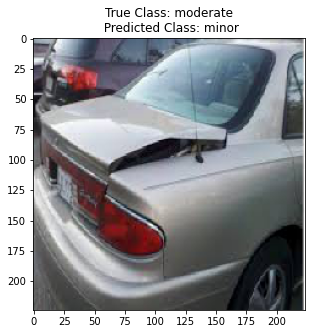

In [ ]:
# Plotting a random image from test data that was classified incorrectly by our model

idxs = np.argwhere(test_true!=test_preds).ravel()
test_img_idx = np.random.choice(idxs, 1)[0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Initialise an image generator object for test data
datagen = ImageDataGenerator(
    rescale=1./255)
# iterator
aug_iter = datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image_orig, label = aug_iter.next()

ax.imshow(np.squeeze(image_orig, axis=0))
ax.set_title('True Class: '+str(labels_list[np.argmax(label, axis=1)[0]])+'\n Predicted Class: '+str(labels_list[int(test_preds[test_img_idx])]))

Found 171 images belonging to 3 classes.


Text(0.5, 0.9, "Feature Maps from 'conv2_block2_concat' Layer")

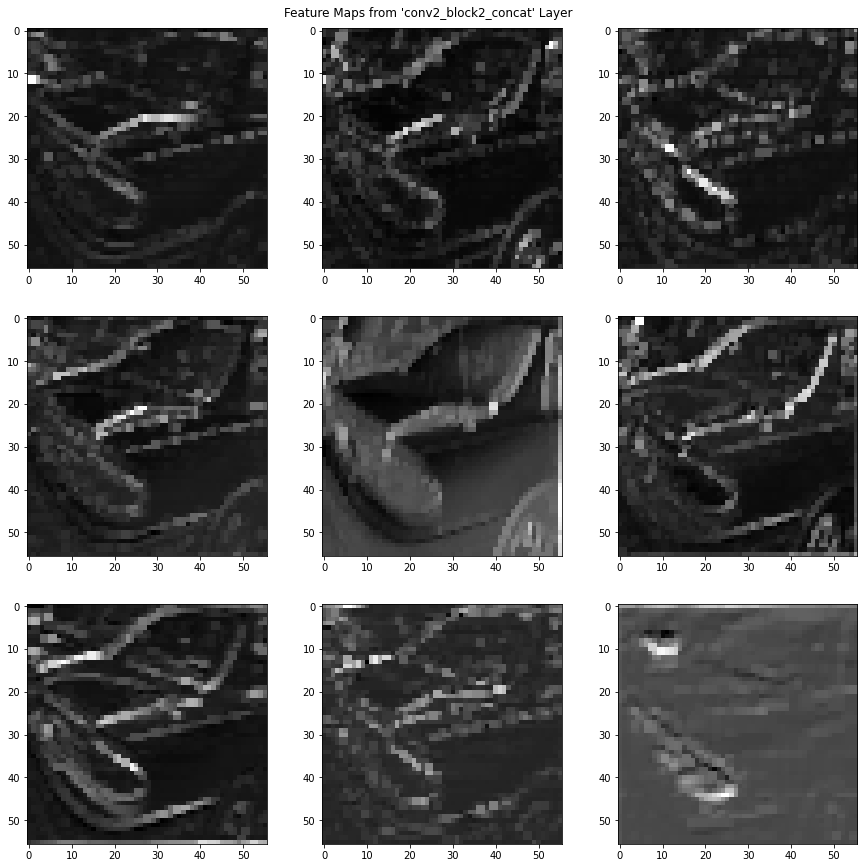

In [ ]:
# Plotting 9 feature maps from a specified layer of our model

# iterator
aug_iter = test_datagen.flow_from_directory(DATA3_TEST_PATH, target_size=target_size, color_mode='rgb',
    class_mode='categorical', batch_size=1, shuffle=False)
for i in range(test_img_idx+1):
  image, label = aug_iter.next()

# Specify layer number
layer_idx = 20

# get feature maps from the specified layer
feat_maps = get_feature_maps(best_model_data3, layer_idx, image)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i in range(3):
  for j in range(3):
    ax[i, j].imshow(feat_maps[i*3+j], cmap='gray')
plt.suptitle("Feature Maps from '"+str(best_model_data3.layers[layer_idx].name)+"' Layer", y=0.9)

In [ ]:
# Importing relevant libraries to work with SmoothGrad and GradCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

(-0.5, 223.5, 223.5, -0.5)

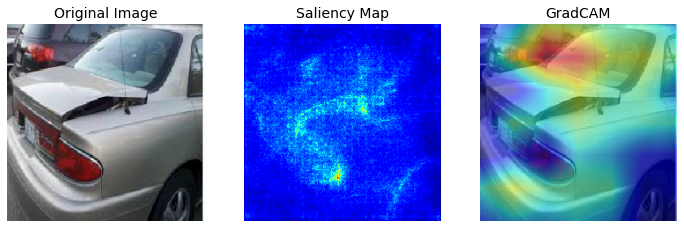

In [ ]:
# Plotting Original Image, SmoothGrad Saliency Map and GradCAM 

# specifying model_modifier. ReplaceToLinear() is used when the model output layer uses softmax activation.
replace2linear = ReplaceToLinear()

# specifying score function. CategoricalScore() is used because the model predicts classes.
score = CategoricalScore(int(test_preds[test_img_idx]))

# Create Saliency object.
saliency = Saliency(best_model_data3,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        image,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## normalizing saliency_map outputs
saliency_map = normalize(saliency_map)

# Create Gradcam object
gradcam = Gradcam(best_model_data3,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              image,
              penultimate_layer=-1)

## normalizing cam outputs
cam = normalize(cam)

image_titles = ['Original Image', 'Saliency Map', 'GradCAM']

# Render
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(np.squeeze(image_orig, axis=0))
ax[0].set_title(image_titles[0], fontsize=14)
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title(image_titles[1], fontsize=14)
ax[1].axis('off')

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[2].imshow(np.squeeze(image_orig, axis=0))
ax[2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
ax[2].set_title(image_titles[2], fontsize=14)
ax[2].axis('off')

# plt.savefig('images/smoothgrad.png')

## SIMPLE REGULARIZED LOGISTIC REGRESSION

In [ ]:
#DATA 2
#Data Augmentation
from tensorflow.keras.applications.densenet import preprocess_input
import random
batch_size = 32
target_size = (224,224)
datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input,shear_range = 0.2, zoom_range = 0.2,horizontal_flip=True,rotation_range=random.randint(-20,20),validation_split=0.2)
datagen3= ImageDataGenerator(preprocessing_function=preprocess_input,shear_range = 0.2, zoom_range = 0.2,horizontal_flip=True,rotation_range=random.randint(-20,20))
traingen1 = datagen2.flow_from_directory(directory = DATA2_TRAIN_PATH, color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical',subset="training")
valgen1=datagen2.flow_from_directory(directory = DATA2_TRAIN_PATH, color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical',subset="validation")
testgen1 = datagen3.flow_from_directory(directory = DATA2_TEST_PATH,color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical')

#Training the fully connected meural network layers of Densenet pretrained model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

base_model=DenseNet121(include_top=False,input_shape=(224,224,3))
base_model.trainable=False
x=base_model.output
x=Flatten()(x)
preds=Dense(3,activation="softmax",activity_regularizer=tf.keras.regularizers.l2(0.001))(x)

model=Model(inputs=base_model.input,outputs=preds)
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(traingen1.classes),y=traingen1.classes)

train_class_weights = dict(enumerate(class_weights))
filepath="/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/densenet_4.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')
#compiling the model
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.Adam())
#callback = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
#model fit
step_size_train=traingen1.n//traingen1.batch_size
step_size_validation=valgen1.n//valgen1.batch_size

model.fit(traingen1,validation_data=valgen1,class_weight=train_class_weights,epochs=40,steps_per_epoch=step_size_train,validation_steps=step_size_validation,callbacks=[checkpoint])

best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/densenet_4.hdf5')
testgen1 = datagen3.flow_from_directory(directory = DATA2_TEST_PATH,color_mode="rgb",target_size = target_size, batch_size=1, class_mode='categorical',shuffle=False)
y_pred=best_model.predict(testgen1)
y_pred=list(np.argmax(y_pred,axis=1))

from sklearn.metrics import accuracy_score,classification_report
y_true = testgen1.classes
print(accuracy_score(y_true,np.array(y_pred)))
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# DATA 3
#Data Augmentation
from tensorflow.keras.applications.densenet import preprocess_input
import random
batch_size = 32
target_size = (224,224)
datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input,shear_range = 0.2, zoom_range = 0.2,horizontal_flip=True,rotation_range=random.randint(-20,20),validation_split=0.2)
datagen3= ImageDataGenerator(preprocessing_function=preprocess_input,shear_range = 0.2, zoom_range = 0.2,horizontal_flip=True,rotation_range=random.randint(-20,20))
traingen1 = datagen2.flow_from_directory(directory = DATA3_TRAIN_PATH, color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical',subset="training")
valgen1=datagen2.flow_from_directory(directory = DATA3_TRAIN_PATH, color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical',subset="validation")
testgen1 = datagen3.flow_from_directory(directory = DATA3_TEST_PATH,color_mode="rgb",target_size = target_size, batch_size = batch_size, class_mode='categorical')

#Training the fully connected meural network layers of Densenet pretrained model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

base_model=DenseNet121(include_top=False,input_shape=(224,224,3))
base_model.trainable=False
x=base_model.output
x=Flatten()(x)
preds=Dense(3,activation="softmax",activity_regularizer=tf.keras.regularizers.l2(1))(x)

model=Model(inputs=base_model.input,outputs=preds)
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(traingen1.classes),y=traingen1.classes)

train_class_weights = dict(enumerate(class_weights))
filepath="/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/densenet_4.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')
#compiling the model
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.Adam())
#callback = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
#model fit
step_size_train=traingen1.n//traingen1.batch_size
step_size_validation=valgen1.n//valgen1.batch_size

model.fit(traingen1,validation_data=valgen1,class_weight=train_class_weights,epochs=40,steps_per_epoch=step_size_train,validation_steps=step_size_validation,callbacks=[checkpoint])

best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/car-damage-dataset/densenet_4.hdf5')
testgen1 = datagen3.flow_from_directory(directory = DATA3_TEST_PATH,color_mode="rgb",target_size = target_size, batch_size=1, class_mode='categorical',shuffle=False)
y_pred=best_model.predict(testgen1)
y_pred=list(np.argmax(y_pred,axis=1))

from sklearn.metrics import accuracy_score,classification_report
y_true = testgen1.classes
print(accuracy_score(y_true,np.array(y_pred)))
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))


**Observation:** <font color='red'>Simple regularized Logistic regression was tried on different stages of datasets for different architectures (like VGG,Resnet,Densenet), a few of which (densenet architecture on dataset 2 and 3) has been illutrated above. However, improvement in model performance was not observed compared to final selected model. For example, in the above case, for dataset 3, accuracy of 61% and for dataset 2, 68% accuracy was achieved. However, the uplift in accuracy seen using more complex architecture was not by a very high margin.</font>

## BUILDING A WEB APP USING STREAMLIT

In [ ]:
!pip install streamlit -q

     |████████████████████████████████| 9.2 MB 4.2 MB/s 
     |████████████████████████████████| 180 kB 48.9 MB/s 
     |████████████████████████████████| 4.3 MB 36.0 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 164 kB 46.6 MB/s 
     |████████████████████████████████| 111 kB 47.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 126 kB 30.7 MB/s 
     |████████████████████████████████| 791 kB 54.7 MB/s 
     |████████████████████████████████| 374 kB 55.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.6.0 which is incompatible.
google-colab 1.0.0 requires ipytho

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import cv2
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras import applications

st.title('CAR DAMAGE ASSESSMENT')

@st.cache(allow_output_mutation=True)
def load_model():
  # Load the saved model stored at checkpoint_filepath
  DATA1_MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data1/resnet152'
  DATA2_MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data2/resnet152'
  DATA3_MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/AI-2 Project/Car Damage Assessment/models/data3/densenet201'

  # Recreate the exact same model, including its weights and the optimizer
  data1_model = tf.keras.models.load_model(DATA1_MODEL_PATH+'resnet152_data1.h5')
  data2_model = tf.keras.models.load_model(DATA2_MODEL_PATH+'resnet152_data2.h5')
  data3_model = tf.keras.models.load_model(DATA3_MODEL_PATH+'densenet201_data3.h5')

  return data1_model, data2_model, data3_model

with st.spinner('Model is being loaded..'):
  data1_model, data2_model, data3_model = load_model()

st.set_option('deprecation.showfileUploaderEncoding', False)
file = st.file_uploader("Upload Image", type=["jpeg", "jpg","png"])

def import_and_predict(image, data1_model, data2_model, data3_model):
  pred_class = []
  pred_score = []
  
  data1_class = ['damage', 'whole']
  data2_class = ['FRONT', 'REAR', 'SIDE']
  data3_class = ['MINOR', 'MODERATE', 'SEVERE']
  
  target_size = (224,224)
    
  # image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  # image = np.asarray(image)
  # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
  img = np.array(image.resize(target_size))
  img = tf.cast(img, tf.float32)
  img1 = applications.resnet50.preprocess_input(img)
  img2 = applications.resnet50.preprocess_input(img)
  img3 = applications.densenet.preprocess_input(img)

  # img_reshape = img[np.newaxis,...]
  img1 = tf.expand_dims(img1, axis=0)
  img2 = tf.expand_dims(img2, axis=0)
  img3 = tf.expand_dims(img3, axis=0)
  
  pred1_proba = data1_model.predict(img1)
  pred_score.append(1-pred1_proba.ravel()[0])
  pred2_proba = data2_model.predict(img2)
  pred_score.append(np.max(pred2_proba, axis=1)[0])
  pred3_proba = data3_model.predict(img3)
  pred_score.append(np.max(pred3_proba, axis=1)[0])

  pred1 = np.where(pred1_proba.ravel()>=0.5, 1, 0)
  pred_class.append(data1_class[pred1[0]])
  pred2 = np.argmax(pred2_proba, axis=1)
  pred_class.append(data2_class[pred2[0]])
  pred3 = np.argmax(pred3_proba, axis=1)
  pred_class.append(data3_class[pred3[0]])

  return pred_class, pred_score

if file is None:
  st.write("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)
  pred_class, pred_score = import_and_predict(image, data1_model, data2_model, data3_model)

  if pred_class[0] == 'whole':
    st.subheader("Are you SURE the vehicle is damaged? PLEASE CHECK ONCE.")
  else:
    msg = f"The vehicle is DAMAGED (confidence: {100*pred_score[0]:.2f}%) on the {pred_class[1]} (confidence: {100*pred_score[1]:.2f}%) suffering {pred_class[2]} (confidence: {100*pred_score[2]:.2f}%) damages."
    st.subheader(msg)
  # st.write(prediction)
  # st.write(score)
  # print(
  # "This image most likely belongs to {} with a {:.2f} percent confidence."
  # .format(class_names[np.argmax(score)], 100 * np.max(score)))

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

2021-12-24 16:38:34.446856: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-12-24 16:38:34.447665: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-12-24 16:38:34.447709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.80.249.168:8501

npx: installed 22 in 4.525s
your url is: https://new-snail-56.loca.lt
2